Realizamos los importes necesarios usados durante todo el cuaderno

In [1]:
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import json
from google.colab import drive
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler

Montamos el directorio de drive donde se encuentran los datos con los que vamos a trabajar

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


#Preparación de las variables externas

Leemos el arhcivo .json donde se encuentran los datos de las variables externas y montamos un dataframe con los mismos

In [3]:
with open('/content/drive/MyDrive/DataLake_TFG/datos_metereologicos.json', 'r') as file:
    data = json.load(file)

In [4]:
df_clima = pd.DataFrame(data)

In [5]:
df_clima.head()

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2020-11-09,4067,MADRIDEJOS,TOLEDO,690,"11,7","2,0","6,6",23:40,"16,8",15:20,21,"2,2","9,2",14:10,"3,2","944,5",Varias,"940,6",03
1,2020-11-10,4067,MADRIDEJOS,TOLEDO,690,"9,6","0,0","3,6",Varias,"15,6",16:00,28,"1,7","6,4",05:40,"5,3","946,9",11,"944,2",03
2,2020-11-11,4067,MADRIDEJOS,TOLEDO,690,"9,0","0,2","2,9",06:50,"15,2",16:00,10,"3,1","6,7",10:30,"3,8","946,0",Varias,"942,4",Varias
3,2020-11-12,4067,MADRIDEJOS,TOLEDO,690,"9,6","0,0","3,3",06:10,"15,8",14:40,10,"2,8","9,7",13:10,"6,6","943,5",00,"939,5",16
4,2020-11-13,4067,MADRIDEJOS,TOLEDO,690,"10,2","0,2","3,7",07:00,"16,7",14:40,11,"0,8","6,7",09:40,"7,3","941,3",11,"939,3",15


Quitamos las columnas que no parecen importantes para nuestro proyecto

In [6]:
df_clima.drop(['indicativo','nombre','provincia','horatmin','horatmax','horaracha','horaPresMax','horaPresMin','altitud'], axis=1, inplace=True)
df_clima.head()

,fecha,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,"11,7","2,0","6,6","16,8",21,"2,2","9,2","3,2","944,5","940,6"
1,2020-11-10,"9,6","0,0","3,6","15,6",28,"1,7","6,4","5,3","946,9","944,2"
2,2020-11-11,"9,0","0,2","2,9","15,2",10,"3,1","6,7","3,8","946,0","942,4"
3,2020-11-12,"9,6","0,0","3,3","15,8",10,"2,8","9,7","6,6","943,5","939,5"
4,2020-11-13,"10,2","0,2","3,7","16,7",11,"0,8","6,7","7,3","941,3","939,3"


Ponemos la columna fecha en su formato correcto y la renombramos como 'ds' para porder trabajar con ella con prophet más adelante, además de otrogar una consistencia a los datos

In [7]:
df_clima['fecha'] = pd.to_datetime(df_clima['fecha'])
df_clima.head()

,fecha,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,"11,7","2,0","6,6","16,8",21,"2,2","9,2","3,2","944,5","940,6"
1,2020-11-10,"9,6","0,0","3,6","15,6",28,"1,7","6,4","5,3","946,9","944,2"
2,2020-11-11,"9,0","0,2","2,9","15,2",10,"3,1","6,7","3,8","946,0","942,4"
3,2020-11-12,"9,6","0,0","3,3","15,8",10,"2,8","9,7","6,6","943,5","939,5"
4,2020-11-13,"10,2","0,2","3,7","16,7",11,"0,8","6,7","7,3","941,3","939,3"


Reemplazamos las comas de los valores decimales por puntos para que Prophet pueda leerlos

In [8]:
columnas = ['tmed', 'prec', 'tmin', 'tmax', 'dir', 'velmedia', 'racha', 'sol', 'presMax', 'presMin']

for columna in columnas:
    df_clima[columna] = df_clima[columna].str.replace(',', '.')

df_clima.head()

,fecha,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,11.7,2.0,6.6,16.8,21,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,9.6,0.0,3.6,15.6,28,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,9.0,0.2,2.9,15.2,10,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,9.6,0.0,3.3,15.8,10,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,10.2,0.2,3.7,16.7,11,0.8,6.7,7.3,941.3,939.3


Imputamos los valores NaN, cambiandolos por una media

In [9]:
imputer = SimpleImputer(strategy='mean')

for columna in columnas:
    df_clima[columna] = imputer.fit_transform(df_clima[[columna]])

df_clima.head()

,fecha,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,11.7,2.0,6.6,16.8,21.0,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,9.6,0.0,3.6,15.6,28.0,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,9.0,0.2,2.9,15.2,10.0,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,9.6,0.0,3.3,15.8,10.0,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,10.2,0.2,3.7,16.7,11.0,0.8,6.7,7.3,941.3,939.3


#Datos de un solo cliente

##Datos del primer cliente

Leemos el archivo .csv que contiene los datos del consumo del cliente

In [ ]:
df_cliente1 = pd.read_csv('/content/drive/MyDrive/DataLake_TFG/DatosClientes/ConsumoHorario_Cliente1.csv', sep=',')
df_cliente1.head()

,FechaHora,Consumo
0,2020-11-09 00:00:00,126.0
1,2020-11-09 01:00:00,80.0
2,2020-11-09 02:00:00,49.0
3,2020-11-09 03:00:00,103.0
4,2020-11-09 04:00:00,122.0


Convertimos las fechas de la columna "FechaHora" a su tipo correcto

In [ ]:
df_cliente1['FechaHora'] = pd.to_datetime(df_cliente1['FechaHora'])

###Datos originales

Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size1 = int(len(df_cliente1) * 0.8)
train_data1, test_data1 = df_cliente1[:train_size1], df_cliente1[train_size1:]

Escalamos la columna "Consumo" en train_data y en test_data para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data1['Consumo'] = scaler.fit_transform(train_data1[['Consumo']])
test_data1['Consumo'] = scaler.transform(test_data1[['Consumo']])

<ipython-input-6-ec56f4278e79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Consumo'] = scaler.fit_transform(train_data1[['Consumo']])
<ipython-input-6-ec56f4278e79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Consumo'] = scaler.transform(test_data1[['Consumo']])


Toamamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM

In [ ]:
def create_sequences(data1, seq_length):
    X = []
    y = []
    for i in range(len(data1) - seq_length):
        X.append(data1['Consumo'].values[i:i+seq_length])
        y.append(data1['Consumo'].values[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train1, y_train1 = create_sequences(train_data1, seq_length)
X_test1, y_test1 = create_sequences(test_data1, seq_length)

Transformamos los conjuntos de datos X_train y X_test en un formato tridimensional adecuado para su uso

In [ ]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], seq_length, 1))
X_test1 = np.reshape(X_test1, (X_test1.shape[0], seq_length, 1))

model = Sequential(): Creamos una instancia del modelo secuencial. El modelo secuencial es una pila lineal de capas de red neuronal, donde cada capa se conecta directamente con la capa siguiente. Es uno de los tipos de modelos más comunes en Keras

model.add(LSTM(50, input_shape=(seq_length, 1))): Agregamos una capa LSTM (Long Short-Term Memory) al modelo. La capa LSTM es una capa recurrente especializada en el procesamiento de secuencias de datos. Recibe una secuencia de entrada de longitud seq_length y una dimensión de características de 1. En este caso, se configura con 50 unidades de memoria

model.add(Dense(1)): Agregamos una capa densa al modelo. Esta capa densa tiene una sola unidad, que representa la salida del modelo

model.compile(loss='mse', optimizer='adam'):  Compilamos el modelo utilizando la función de pérdida de error cuadrático medio (mse) y el optimizador Adam que es un algoritmo de optimización popular que se adapta dinámicamente a la tasa de aprendizaje durante el entrenamiento de la red.

In [ ]:
modeloCliente1 = Sequential()
modeloCliente1.add(LSTM(50, input_shape=(seq_length, 1)))
modeloCliente1.add(Dense(1))
modeloCliente1.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train, y_train) durante 10 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloCliente1.fit(X_train1, y_train1, epochs=10, batch_size=1)

Epoch 1/10
13012/13012 [==============================] - 68s 5ms/step - loss: 0.0013
Epoch 2/10
13012/13012 [==============================] - 81s 6ms/step - loss: 0.0012
Epoch 3/10
13012/13012 [==============================] - 74s 6ms/step - loss: 0.0012
Epoch 4/10
13012/13012 [==============================] - 50s 4ms/step - loss: 0.0011
Epoch 5/10
13012/13012 [==============================] - 66s 5ms/step - loss: 0.0011
Epoch 6/10
13012/13012 [==============================] - 58s 4ms/step - loss: 0.0011
Epoch 7/10
13012/13012 [==============================] - 64s 5ms/step - loss: 0.0011
Epoch 8/10
13012/13012 [==============================] - 59s 5ms/step - loss: 0.0011
Epoch 9/10
13012/13012 [==============================] - 54s 4ms/step - loss: 0.0011
Epoch 10/10
13012/13012 [==============================] - 57s 4ms/step - loss: 0.0011


 Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred1 = modeloCliente1.predict(X_test1)
y_pred1 = scaler.inverse_transform(y_pred1)

102/102 [==============================] - 1s 3ms/step


Tomamos una columna de fechas del DataFrame test_data, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates1 = pd.to_datetime(test_data1['FechaHora'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

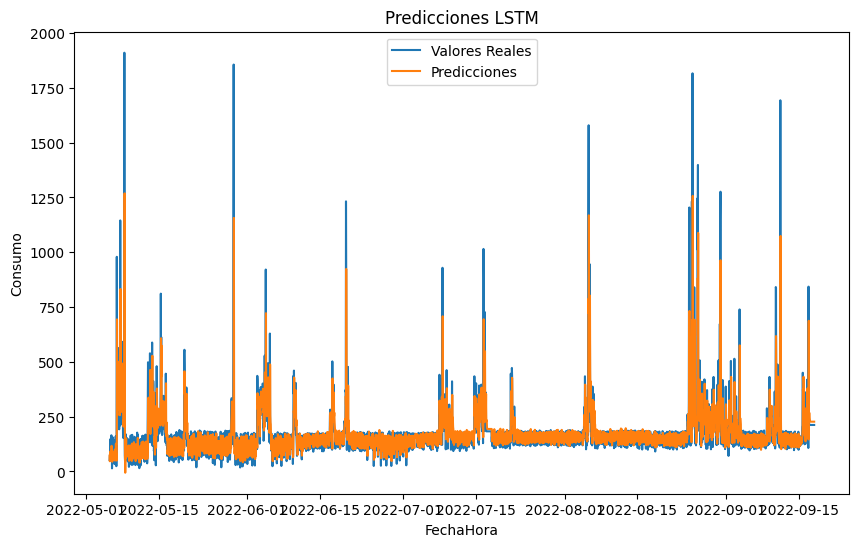

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates1, scaler.inverse_transform(y_test1.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates1, y_pred1, label='Predicciones')
plt.xlabel('FechaHora')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss1 = modeloCliente1.evaluate(X_train1, y_train1, verbose=0)
test_loss1 = modeloCliente1.evaluate(X_test1, y_test1, verbose=0)
print('Train Loss:', train_loss1)
print('Test Loss:', test_loss1)

Train Loss: 0.001076486543752253
Test Loss: 0.0006599396001547575


In [ ]:
modeloCliente1.save('/content/drive/MyDrive/DataLake_TFG/modeloLSTM.h5')

A partir de este punto los datos usados estarán agrupados por días, es decir, asignaremos a cada día el consumo total realizado en ese día y probaremos a añadir valirables externas para ver que efecto tienen en la predicción

###Datos agrupados con variables externas

Creamos un nueva columna "Fecha" que tendrá todas las fechas sin la parte horaria y agrupamos con la columna de consumo para tener el total de energía que se consumio ese día

In [ ]:
df_cliente1['fecha'] = df_cliente1['FechaHora'].dt.date
df_agrupado1 = df_cliente1.groupby('fecha')['Consumo'].sum().reset_index()
df_agrupado1.head()

,fecha,Consumo
0,2020-11-09,2290.0
1,2020-11-10,2370.0
2,2020-11-11,2412.0
3,2020-11-12,3312.0
4,2020-11-13,2322.0


Convertimos las fechas de la columna "fecha" a su tipo correcto

In [ ]:
df_agrupado1['fecha'] = pd.to_datetime(df_agrupado1['fecha'])

Juntamos los dataframe con los datos agrupados y las variables externas previamente preparadas usando de pivote la columna fecha, la cual debe coincidir en ambas tablas para se haga correctamente

In [ ]:
df_total1 = pd.merge(df_agrupado1, df_clima, on='fecha')
df_total1

,fecha,Consumo,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,2290.0,11.7,2.0,6.6,16.8,21.0,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,2370.0,9.6,0.0,3.6,15.6,28.0,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,2412.0,9.0,0.2,2.9,15.2,10.0,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,3312.0,9.6,0.0,3.3,15.8,10.0,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,2322.0,10.2,0.2,3.7,16.7,11.0,0.8,6.7,7.3,941.3,939.3
...,...,...,...,...,...,...,...,...,...,...,...,...
652,2022-09-13,3324.0,22.2,1.0,17.8,26.6,19.0,4.7,16.7,6.0,932.6,930.1
653,2022-09-14,3434.0,21.2,0.0,16.1,26.3,23.0,3.3,13.9,6.7,935.3,931.7
654,2022-09-15,4913.0,20.4,0.6,16.2,24.6,30.0,1.7,11.4,4.6,936.5,934.6
655,2022-09-16,5464.0,21.0,0.0,14.2,27.9,29.0,1.7,7.8,12.0,936.6,933.2


Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size_ex1 = int(len(df_total1) * 0.8)
train_data_ex1, test_data_ex1 = df_total1[:train_size_ex1], df_total1[train_size_ex1:]

Escalamos la columna "Consumo" y todas las variables externas que se van a utilizar en el modelo, en train_data_ex y en test_data_ex para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data_ex1['Consumo'] = scaler.fit_transform(train_data_ex1[['Consumo']])
train_data_ex1['tmed'] = scaler.fit_transform(train_data_ex1[['tmed']])
train_data_ex1['prec'] = scaler.fit_transform(train_data_ex1[['prec']])
train_data_ex1['tmin'] = scaler.fit_transform(train_data_ex1[['tmin']])
train_data_ex1['tmax'] = scaler.fit_transform(train_data_ex1[['tmax']])
train_data_ex1['dir'] = scaler.fit_transform(train_data_ex1[['dir']])
train_data_ex1['velmedia'] = scaler.fit_transform(train_data_ex1[['velmedia']])
train_data_ex1['racha'] = scaler.fit_transform(train_data_ex1[['racha']])
train_data_ex1['sol'] = scaler.fit_transform(train_data_ex1[['sol']])
train_data_ex1['presMax'] = scaler.fit_transform(train_data_ex1[['presMax']])
train_data_ex1['presMin'] = scaler.fit_transform(train_data_ex1[['presMin']])

test_data_ex1['Consumo'] = scaler.fit_transform(test_data_ex1[['Consumo']])
test_data_ex1['tmed'] = scaler.fit_transform(test_data_ex1[['tmed']])
test_data_ex1['prec'] = scaler.fit_transform(test_data_ex1[['prec']])
test_data_ex1['tmin'] = scaler.fit_transform(test_data_ex1[['tmin']])
test_data_ex1['tmax'] = scaler.fit_transform(test_data_ex1[['tmax']])
test_data_ex1['dir'] = scaler.fit_transform(test_data_ex1[['dir']])
test_data_ex1['velmedia'] = scaler.fit_transform(test_data_ex1[['velmedia']])
test_data_ex1['racha'] = scaler.fit_transform(test_data_ex1[['racha']])
test_data_ex1['sol'] = scaler.fit_transform(test_data_ex1[['sol']])
test_data_ex1['presMax'] = scaler.fit_transform(test_data_ex1[['presMax']])
test_data_ex1['presMin'] = scaler.fit_transform(test_data_ex1[['presMin']])

<ipython-input-33-1ba91f91566d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex1['Consumo'] = scaler.fit_transform(train_data_ex1[['Consumo']])
<ipython-input-33-1ba91f91566d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex1['tmed'] = scaler.fit_transform(train_data_ex1[['tmed']])
<ipython-input-33-1ba91f91566d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM con variables externas

In [ ]:
def create_sequences(data_ex, seq_length):
    X_seq1 = []
    X1_ext1 = []
    X1_ext2 = []
    X1_ext3 = []
    X1_ext4 = []
    X1_ext5 = []
    X1_ext6 = []
    X1_ext7 = []
    X1_ext8 = []
    X1_ext9 = []
    X1_ext10 = []
    y1 = []
    for i in range(len(data_ex) - seq_length):
        X_seq1.append(data_ex['Consumo'].values[i:i+seq_length])
        X1_ext1.append(data_ex['tmed'].values[i:i+seq_length])
        X1_ext2.append(data_ex['prec'].values[i:i+seq_length])
        X1_ext3.append(data_ex['tmin'].values[i:i+seq_length])
        X1_ext4.append(data_ex['tmax'].values[i:i+seq_length])
        X1_ext5.append(data_ex['dir'].values[i:i+seq_length])
        X1_ext6.append(data_ex['velmedia'].values[i:i+seq_length])
        X1_ext7.append(data_ex['racha'].values[i:i+seq_length])
        X1_ext8.append(data_ex['sol'].values[i:i+seq_length])
        X1_ext9.append(data_ex['presMax'].values[i:i+seq_length])
        X1_ext10.append(data_ex['presMin'].values[i:i+seq_length])
        y1.append(data_ex['Consumo'].values[i+seq_length])
    return np.array(X_seq1), np.array(X1_ext1), np.array(X1_ext2), np.array(X1_ext3), np.array(X1_ext4), np.array(X1_ext5), np.array(X1_ext6), np.array(X1_ext7), np.array(X1_ext8), np.array(X1_ext9), np.array(X1_ext10), np.array(y1)

seq_length = 5
X_train_seq1, X1_train_ext1, X1_train_ext2, X1_train_ext3, X1_train_ext4, X1_train_ext5, X1_train_ext6, X1_train_ext7, X1_train_ext8, X1_train_ext9, X1_train_ext10, y_train_ex1 = create_sequences(train_data_ex1, seq_length)
X_test_seq1, X_test_ext1,  X_test_ext2,  X_test_ext3,  X_test_ext4,  X_test_ext5,  X_test_ext6,  X_test_ext7,  X_test_ext8,  X_test_ext9,  X_test_ext10, y_test_ex1 = create_sequences(test_data_ex1, seq_length)

Transformamos los conjuntos de datos X_train_seq y X_test_seq en un formato tridimensional adecuado para su uso

In [ ]:
X_train_seq1 = np.reshape(X_train_seq1, (X_train_seq1.shape[0], seq_length, 1))
X_test_seq1 = np.reshape(X_test_seq1, (X_test_seq1.shape[0], seq_length, 1))

Definimos 11 conjuntos de datos de entrada, cada uno representado por un objeto Input de Keras con la forma (seq_length, 1). Esto indica que cada secuencia de entrada tiene una longitud de seq_length y una dimensión de 1

Después, definimos una capa LSTM con 50 unidades para cada uno de los 11 conjuntos de entrada (11 LSTMs en total). Esto se hace mediante la llamada a LSTM(50) con cada uno de los objetos Input como entrada.

Luego, todas las salidas de las LSTMs (11 en total) se concatenan usando "keras.layers.concatenate". La salida concatenada resultante será una sola secuencia.

Después de la concatenación, se agrega una capa Dense con una sola unidad para producir la salida final.

Finalmente, se crea el modelo utilizando Model, definiendo los 11 objetos Input como entradas y el objeto Dense como salida. El modelo se compila utilizando la función de pérdida de error cuadrático medio ('mse') y el optimizador Adam ('adam') para el entrenamiento.

In [ ]:
seq_input1 = Input(shape=(seq_length, 1))
ext1_input1 = Input(shape=(seq_length, 1))
ext1_input2 = Input(shape=(seq_length, 1))
ext1_input3 = Input(shape=(seq_length, 1))
ext1_input4 = Input(shape=(seq_length, 1))
ext1_input5 = Input(shape=(seq_length, 1))
ext1_input6 = Input(shape=(seq_length, 1))
ext1_input7 = Input(shape=(seq_length, 1))
ext1_input8 = Input(shape=(seq_length, 1))
ext1_input9 = Input(shape=(seq_length, 1))
ext1_input10 = Input(shape=(seq_length, 1))
lstm_seq1 = LSTM(50)(seq_input1)
lstm1_ext1 = LSTM(50)(ext1_input1)
lstm1_ext2 = LSTM(50)(ext1_input2)
lstm1_ext3 = LSTM(50)(ext1_input3)
lstm1_ext4 = LSTM(50)(ext1_input4)
lstm1_ext5 = LSTM(50)(ext1_input5)
lstm1_ext6 = LSTM(50)(ext1_input6)
lstm1_ext7 = LSTM(50)(ext1_input7)
lstm1_ext8 = LSTM(50)(ext1_input8)
lstm1_ext9 = LSTM(50)(ext1_input9)
lstm1_ext10 = LSTM(50)(ext1_input10)
merged1 = keras.layers.concatenate([lstm_seq1, lstm1_ext1, lstm1_ext2, lstm1_ext3, lstm1_ext4, lstm1_ext5, lstm1_ext6, lstm1_ext7, lstm1_ext8, lstm1_ext9, lstm1_ext10])
output1 = Dense(1)(merged1)
modeloAgrupado1 = Model(inputs=[seq_input1, ext1_input1, ext1_input2, ext1_input3, ext1_input4, ext1_input5, ext1_input6, ext1_input7, ext1_input8, ext1_input9, ext1_input10], outputs=output1)
modeloAgrupado1.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train_seq, y_train_ex y todos los conjuntos de datos externos) durante 50 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloAgrupado1.fit([X_train_seq1, X1_train_ext1, X1_train_ext2, X1_train_ext3, X1_train_ext4, X1_train_ext5, X1_train_ext6, X1_train_ext7, X1_train_ext8, X1_train_ext9, X1_train_ext10], y_train_ex1, epochs=50, batch_size=1)

Epoch 1/50
520/520 [==============================] - 11s 20ms/step - loss: 0.0056
Epoch 2/50
520/520 [==============================] - 9s 17ms/step - loss: 0.0055
Epoch 3/50
520/520 [==============================] - 10s 19ms/step - loss: 0.0055
Epoch 4/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0053
Epoch 5/50
520/520 [==============================] - 8s 16ms/step - loss: 0.0052
Epoch 6/50
520/520 [==============================] - 11s 20ms/step - loss: 0.0054
Epoch 7/50
520/520 [==============================] - 12s 23ms/step - loss: 0.0052
Epoch 8/50
520/520 [==============================] - 11s 20ms/step - loss: 0.0053
Epoch 9/50
520/520 [==============================] - 9s 17ms/step - loss: 0.0050
Epoch 10/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0051
Epoch 11/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0051
Epoch 12/50
520/520 [==============================] - 9s 16ms/step - loss: 0.0050
Epoch

Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred_ex1 = modeloAgrupado1.predict([X_test_seq1, X_test_ext1,  X_test_ext2,  X_test_ext3,  X_test_ext4,  X_test_ext5,  X_test_ext6,  X_test_ext7,  X_test_ext8,  X_test_ext9,  X_test_ext10])
y_pred_ex1 = scaler.inverse_transform(y_pred_ex1)

4/4 [==============================] - 0s 10ms/step


Tomamos una columna de fechas del DataFrame test_data_ex, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates_ex1 = pd.to_datetime(test_data_ex1['fecha'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

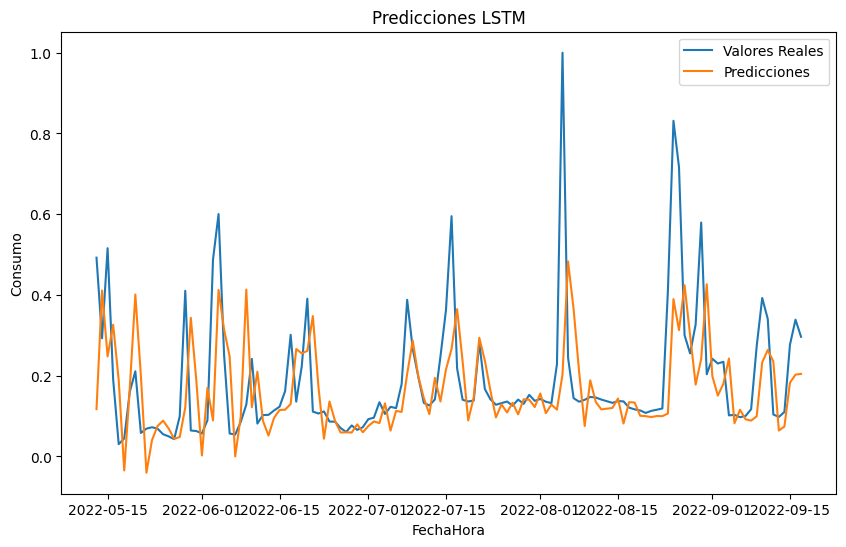

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates_ex1, scaler.inverse_transform(y_test_ex1.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates_ex1, y_pred_ex1, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss_ex1 = modeloAgrupado1.evaluate([X_train_seq1, X1_train_ext1, X1_train_ext2, X1_train_ext3, X1_train_ext4, X1_train_ext5, X1_train_ext6, X1_train_ext7, X1_train_ext8, X1_train_ext9, X1_train_ext10], y_train_ex1, verbose=0)
test_loss_ex1 = modeloAgrupado1.evaluate([X_test_seq1, X_test_ext1,  X_test_ext2,  X_test_ext3,  X_test_ext4,  X_test_ext5,  X_test_ext6,  X_test_ext7,  X_test_ext8,  X_test_ext9,  X_test_ext10], y_test_ex1, verbose=0)
print('Train Loss:', train_loss_ex1)
print('Test Loss:', test_loss_ex1)

Train Loss: 0.0035194698721170425
Test Loss: 0.02229832299053669


##Datos del segundo cliente

Leemos el archivo .csv que contiene los datos del consumo del cliente

In [ ]:
df_cliente2 = pd.read_csv('/content/drive/MyDrive/DataLake_TFG/DatosClientes/ConsumoHorario_Cliente2.csv', sep=',')
df_cliente2.head()

,FechaHora,Consumo
0,2020-11-09 00:00:00,2.0
1,2020-11-09 01:00:00,28.0
2,2020-11-09 02:00:00,109.0
3,2020-11-09 03:00:00,106.0
4,2020-11-09 04:00:00,4.0


Convertimos las fechas de la columna "FechaHora" a su tipo correcto

In [ ]:
df_cliente2['FechaHora'] = pd.to_datetime(df_cliente2['FechaHora'])

###Datos originales

Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size2 = int(len(df_cliente2) * 0.8)
train_data2, test_data2 = df_cliente2[:train_size2], df_cliente2[train_size2:]

Escalamos la columna "Consumo" en train_data y en test_data para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data2['Consumo'] = scaler.fit_transform(train_data2[['Consumo']])
test_data2['Consumo'] = scaler.transform(test_data2[['Consumo']])

<ipython-input-6-57338cc14704>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data2['Consumo'] = scaler.fit_transform(train_data2[['Consumo']])
<ipython-input-6-57338cc14704>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data2['Consumo'] = scaler.transform(test_data2[['Consumo']])


Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM

In [ ]:
def create_sequences(data2, seq_length):
    X = []
    y = []
    for i in range(len(data2) - seq_length):
        X.append(data2['Consumo'].values[i:i+seq_length])
        y.append(data2['Consumo'].values[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train2, y_train2 = create_sequences(train_data2, seq_length)
X_test2, y_test2 = create_sequences(test_data2, seq_length)

Transformamos los conjuntos de datos X_train y X_test en un formato tridimensional adecuado para su uso

In [ ]:
X_train2 = np.reshape(X_train2, (X_train2.shape[0], seq_length, 1))
X_test2 = np.reshape(X_test2, (X_test2.shape[0], seq_length, 1))

model = Sequential(): Creamos una instancia del modelo secuencial. El modelo secuencial es una pila lineal de capas de red neuronal, donde cada capa se conecta directamente con la capa siguiente. Es uno de los tipos de modelos más comunes en Keras

model.add(LSTM(50, input_shape=(seq_length, 1))): Agregamos una capa LSTM (Long Short-Term Memory) al modelo. La capa LSTM es una capa recurrente especializada en el procesamiento de secuencias de datos. Recibe una secuencia de entrada de longitud seq_length y una dimensión de características de 1. En este caso, se configura con 50 unidades de memoria

model.add(Dense(1)): Agregamos una capa densa al modelo. Esta capa densa tiene una sola unidad, que representa la salida del modelo

model.compile(loss='mse', optimizer='adam'):  Compilamos el modelo utilizando la función de pérdida de error cuadrático medio (mse) y el optimizador Adam que es un algoritmo de optimización popular que se adapta dinámicamente a la tasa de aprendizaje durante el entrenamiento de la red.

In [ ]:
modeloCliente2 = Sequential()
modeloCliente2.add(LSTM(50, input_shape=(seq_length, 1)))
modeloCliente2.add(Dense(1))
modeloCliente2.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train, y_train) durante 10 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloCliente2.fit(X_train2, y_train2, epochs=10, batch_size=1)

Epoch 1/10
13012/13012 [==============================] - 54s 4ms/step - loss: 0.0169
Epoch 2/10
13012/13012 [==============================] - 49s 4ms/step - loss: 0.0163
Epoch 3/10
13012/13012 [==============================] - 49s 4ms/step - loss: 0.0159
Epoch 4/10
13012/13012 [==============================] - 48s 4ms/step - loss: 0.0154
Epoch 5/10
13012/13012 [==============================] - 47s 4ms/step - loss: 0.0152
Epoch 6/10
13012/13012 [==============================] - 47s 4ms/step - loss: 0.0152
Epoch 7/10
13012/13012 [==============================] - 46s 4ms/step - loss: 0.0151
Epoch 8/10
13012/13012 [==============================] - 47s 4ms/step - loss: 0.0150
Epoch 9/10
13012/13012 [==============================] - 47s 4ms/step - loss: 0.0150
Epoch 10/10
13012/13012 [==============================] - 46s 4ms/step - loss: 0.0150


 Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred2 = modeloCliente2.predict(X_test2)
y_pred2 = scaler.inverse_transform(y_pred2)

102/102 [==============================] - 1s 2ms/step


Tomamos una columna de fechas del DataFrame test_data, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates2 = pd.to_datetime(test_data2['FechaHora'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

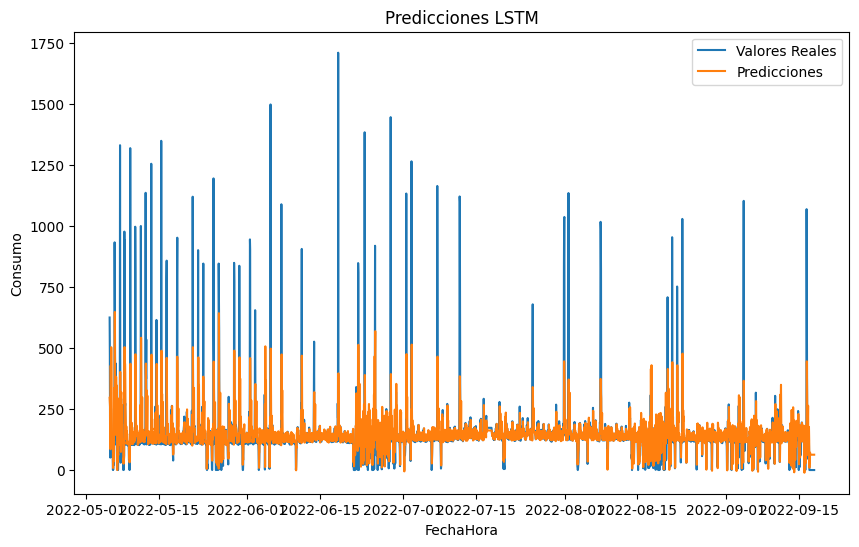

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates2, scaler.inverse_transform(y_test2.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates2, y_pred2, label='Predicciones')
plt.xlabel('FechaHora')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss2 = modeloCliente2.evaluate(X_train2, y_train2, verbose=0)
test_loss2 = modeloCliente2.evaluate(X_test2, y_test2, verbose=0)
print('Train Loss:', train_loss2)
print('Test Loss:', test_loss2)

Train Loss: 0.014646725729107857
Test Loss: 0.0038782316260039806


A partir de este punto los datos usados estarán agrupados por días, es decir, asignaremos a cada día el consumo total realizado en ese día y probaremos a añadir valirables externas para ver que efecto tienen en la predicción

###Datos agrupados con variables externas

Creamos un nueva columna "Fecha" que tendrá todas las fechas sin la parte horaria y agrupamos con la columna de consumo para tener el total de energía que se consumio ese día

In [ ]:
df_cliente2['fecha'] = df_cliente2['FechaHora'].dt.date
df_agrupado2 = df_cliente2.groupby('fecha')['Consumo'].sum().reset_index()
df_agrupado2.head()

,fecha,Consumo
0,2020-11-09,4272.0
1,2020-11-10,3832.0
2,2020-11-11,4830.0
3,2020-11-12,312.0
4,2020-11-13,5355.0


Convertimos las fechas de la columna "fecha" a su tipo correcto

In [ ]:
df_agrupado2['fecha'] = pd.to_datetime(df_agrupado2['fecha'])

Juntamos los dataframe con los datos agrupados y las variables externas previamente preparadas usando de pivote la columna fecha, la cual debe coincidir en ambas tablas para se haga correctamente

In [ ]:
df_total2 = pd.merge(df_agrupado2, df_clima, on='fecha')
df_total2

,fecha,Consumo,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,4272.0,11.7,2.0,6.6,16.8,21.0,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,3832.0,9.6,0.0,3.6,15.6,28.0,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,4830.0,9.0,0.2,2.9,15.2,10.0,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,312.0,9.6,0.0,3.3,15.8,10.0,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,5355.0,10.2,0.2,3.7,16.7,11.0,0.8,6.7,7.3,941.3,939.3
...,...,...,...,...,...,...,...,...,...,...,...,...
652,2022-09-13,2566.0,22.2,1.0,17.8,26.6,19.0,4.7,16.7,6.0,932.6,930.1
653,2022-09-14,2719.0,21.2,0.0,16.1,26.3,23.0,3.3,13.9,6.7,935.3,931.7
654,2022-09-15,2747.0,20.4,0.6,16.2,24.6,30.0,1.7,11.4,4.6,936.5,934.6
655,2022-09-16,4428.0,21.0,0.0,14.2,27.9,29.0,1.7,7.8,12.0,936.6,933.2


Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size_ex2 = int(len(df_total2) * 0.8)
train_data_ex2, test_data_ex2 = df_total2[:train_size_ex2], df_total2[train_size_ex2:]

Escalamos la columna "Consumo" y todas las variables externas que se van a utilizar en el modelo, en train_data_ex y en test_data_ex para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data_ex2['Consumo'] = scaler.fit_transform(train_data_ex2[['Consumo']])
train_data_ex2['tmed'] = scaler.fit_transform(train_data_ex2[['tmed']])
train_data_ex2['prec'] = scaler.fit_transform(train_data_ex2[['prec']])
train_data_ex2['tmin'] = scaler.fit_transform(train_data_ex2[['tmin']])
train_data_ex2['tmax'] = scaler.fit_transform(train_data_ex2[['tmax']])
train_data_ex2['dir'] = scaler.fit_transform(train_data_ex2[['dir']])
train_data_ex2['velmedia'] = scaler.fit_transform(train_data_ex2[['velmedia']])
train_data_ex2['racha'] = scaler.fit_transform(train_data_ex2[['racha']])
train_data_ex2['sol'] = scaler.fit_transform(train_data_ex2[['sol']])
train_data_ex2['presMax'] = scaler.fit_transform(train_data_ex2[['presMax']])
train_data_ex2['presMin'] = scaler.fit_transform(train_data_ex2[['presMin']])

test_data_ex2['Consumo'] = scaler.fit_transform(test_data_ex2[['Consumo']])
test_data_ex2['tmed'] = scaler.fit_transform(test_data_ex2[['tmed']])
test_data_ex2['prec'] = scaler.fit_transform(test_data_ex2[['prec']])
test_data_ex2['tmin'] = scaler.fit_transform(test_data_ex2[['tmin']])
test_data_ex2['tmax'] = scaler.fit_transform(test_data_ex2[['tmax']])
test_data_ex2['dir'] = scaler.fit_transform(test_data_ex2[['dir']])
test_data_ex2['velmedia'] = scaler.fit_transform(test_data_ex2[['velmedia']])
test_data_ex2['racha'] = scaler.fit_transform(test_data_ex2[['racha']])
test_data_ex2['sol'] = scaler.fit_transform(test_data_ex2[['sol']])
test_data_ex2['presMax'] = scaler.fit_transform(test_data_ex2[['presMax']])
test_data_ex2['presMin'] = scaler.fit_transform(test_data_ex2[['presMin']])

<ipython-input-16-7eb84bfb066c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex2['Consumo'] = scaler.fit_transform(train_data_ex2[['Consumo']])
<ipython-input-16-7eb84bfb066c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex2['tmed'] = scaler.fit_transform(train_data_ex2[['tmed']])
<ipython-input-16-7eb84bfb066c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM con variables externas

In [ ]:
def create_sequences(data_ex2, seq_length):
    X_seq2 = []
    X2_ext1 = []
    X2_ext2 = []
    X2_ext3 = []
    X2_ext4 = []
    X2_ext5 = []
    X2_ext6 = []
    X2_ext7 = []
    X2_ext8 = []
    X2_ext9 = []
    X2_ext10 = []
    y2 = []
    for i in range(len(data_ex2) - seq_length):
        X_seq2.append(data_ex2['Consumo'].values[i:i+seq_length])
        X2_ext1.append(data_ex2['tmed'].values[i:i+seq_length])
        X2_ext2.append(data_ex2['prec'].values[i:i+seq_length])
        X2_ext3.append(data_ex2['tmin'].values[i:i+seq_length])
        X2_ext4.append(data_ex2['tmax'].values[i:i+seq_length])
        X2_ext5.append(data_ex2['dir'].values[i:i+seq_length])
        X2_ext6.append(data_ex2['velmedia'].values[i:i+seq_length])
        X2_ext7.append(data_ex2['racha'].values[i:i+seq_length])
        X2_ext8.append(data_ex2['sol'].values[i:i+seq_length])
        X2_ext9.append(data_ex2['presMax'].values[i:i+seq_length])
        X2_ext10.append(data_ex2['presMin'].values[i:i+seq_length])
        y2.append(data_ex2['Consumo'].values[i+seq_length])
    return np.array(X_seq2), np.array(X2_ext1), np.array(X2_ext2), np.array(X2_ext3), np.array(X2_ext4), np.array(X2_ext5), np.array(X2_ext6), np.array(X2_ext7), np.array(X2_ext8), np.array(X2_ext9), np.array(X2_ext10), np.array(y2)

seq_length = 5
X_train_seq2, X2_train_ext1, X2_train_ext2, X2_train_ext3, X2_train_ext4, X2_train_ext5, X2_train_ext6, X2_train_ext7, X2_train_ext8, X2_train_ext9, X2_train_ext10, y_train_ex2 = create_sequences(train_data_ex2, seq_length)
X_test_seq2, X2_test_ext1, X2_test_ext2,  X2_test_ext3,  X2_test_ext4,  X2_test_ext5,  X2_test_ext6,  X2_test_ext7,  X2_test_ext8,  X2_test_ext9,  X2_test_ext10, y_test_ex2 = create_sequences(test_data_ex2, seq_length)

Transformamos los conjuntos de datos X_train_seq y X_test_seq en un formato tridimensional adecuado para su uso

In [ ]:
X_train_seq2 = np.reshape(X_train_seq2, (X_train_seq2.shape[0], seq_length, 1))
X_test_seq2 = np.reshape(X_test_seq2, (X_test_seq2.shape[0], seq_length, 1))

Definimos 11 conjuntos de datos de entrada, cada uno representado por un objeto Input de Keras con la forma (seq_length, 1). Esto indica que cada secuencia de entrada tiene una longitud de seq_length y una dimensión de 1

Después, definimos una capa LSTM con 50 unidades para cada uno de los 11 conjuntos de entrada (11 LSTMs en total). Esto se hace mediante la llamada a LSTM(50) con cada uno de los objetos Input como entrada.

Luego, todas las salidas de las LSTMs (11 en total) se concatenan usando "keras.layers.concatenate". La salida concatenada resultante será una sola secuencia.

Después de la concatenación, se agrega una capa Dense con una sola unidad para producir la salida final.

Finalmente, se crea el modelo utilizando Model, definiendo los 11 objetos Input como entradas y el objeto Dense como salida. El modelo se compila utilizando la función de pérdida de error cuadrático medio ('mse') y el optimizador Adam ('adam') para el entrenamiento.

In [ ]:
seq_input2 = Input(shape=(seq_length, 1))
ext2_input1 = Input(shape=(seq_length, 1))
ext2_input2 = Input(shape=(seq_length, 1))
ext2_input3 = Input(shape=(seq_length, 1))
ext2_input4 = Input(shape=(seq_length, 1))
ext2_input5 = Input(shape=(seq_length, 1))
ext2_input6 = Input(shape=(seq_length, 1))
ext2_input7 = Input(shape=(seq_length, 1))
ext2_input8 = Input(shape=(seq_length, 1))
ext2_input9 = Input(shape=(seq_length, 1))
ext2_input10 = Input(shape=(seq_length, 1))
lstm_seq2 = LSTM(50)(seq_input2)
lstm2_ext1 = LSTM(50)(ext2_input1)
lstm2_ext2 = LSTM(50)(ext2_input2)
lstm2_ext3 = LSTM(50)(ext2_input3)
lstm2_ext4 = LSTM(50)(ext2_input4)
lstm2_ext5 = LSTM(50)(ext2_input5)
lstm2_ext6 = LSTM(50)(ext2_input6)
lstm2_ext7 = LSTM(50)(ext2_input7)
lstm2_ext8 = LSTM(50)(ext2_input8)
lstm2_ext9 = LSTM(50)(ext2_input9)
lstm2_ext10 = LSTM(50)(ext2_input10)
merged2 = keras.layers.concatenate([lstm_seq2, lstm2_ext1, lstm2_ext2, lstm2_ext3, lstm2_ext4, lstm2_ext5, lstm2_ext6, lstm2_ext7, lstm2_ext8, lstm2_ext9, lstm2_ext10])
output2 = Dense(1)(merged2)
modeloAgrupado2 = Model(inputs=[seq_input2, ext2_input1, ext2_input2, ext2_input3, ext2_input4, ext2_input5, ext2_input6, ext2_input7, ext2_input8, ext2_input9, ext2_input10], outputs=output2)
modeloAgrupado2.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train_seq, y_train_ex y todos los conjuntos de datos externos) durante 50 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloAgrupado2.fit([X_train_seq2, X2_train_ext1, X2_train_ext2, X2_train_ext3, X2_train_ext4, X2_train_ext5, X2_train_ext6, X2_train_ext7, X2_train_ext8, X2_train_ext9, X2_train_ext10], y_train_ex2, epochs=50, batch_size=1)

Epoch 1/50
520/520 [==============================] - 30s 18ms/step - loss: 0.0238
Epoch 2/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0176
Epoch 3/50
520/520 [==============================] - 11s 22ms/step - loss: 0.0163
Epoch 4/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0159
Epoch 5/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0161
Epoch 6/50
520/520 [==============================] - 11s 22ms/step - loss: 0.0160
Epoch 7/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0159
Epoch 8/50
520/520 [==============================] - 9s 18ms/step - loss: 0.0154
Epoch 9/50
520/520 [==============================] - 11s 22ms/step - loss: 0.0165
Epoch 10/50
520/520 [==============================] - 11s 22ms/step - loss: 0.0156
Epoch 11/50
520/520 [==============================] - 10s 19ms/step - loss: 0.0153
Epoch 12/50
520/520 [==============================] - 13s 25ms/step - loss: 0.0152
Ep

Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred_ex2 = modeloAgrupado2.predict([X_test_seq2, X2_test_ext1,  X2_test_ext2,  X2_test_ext3,  X2_test_ext4,  X2_test_ext5,  X2_test_ext6,  X2_test_ext7,  X2_test_ext8,  X2_test_ext9,  X2_test_ext10])
y_pred_ex2 = scaler.inverse_transform(y_pred_ex2)

4/4 [==============================] - 8s 10ms/step


Tomamos una columna de fechas del DataFrame test_data_ex, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates_ex2 = pd.to_datetime(test_data_ex2['fecha'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

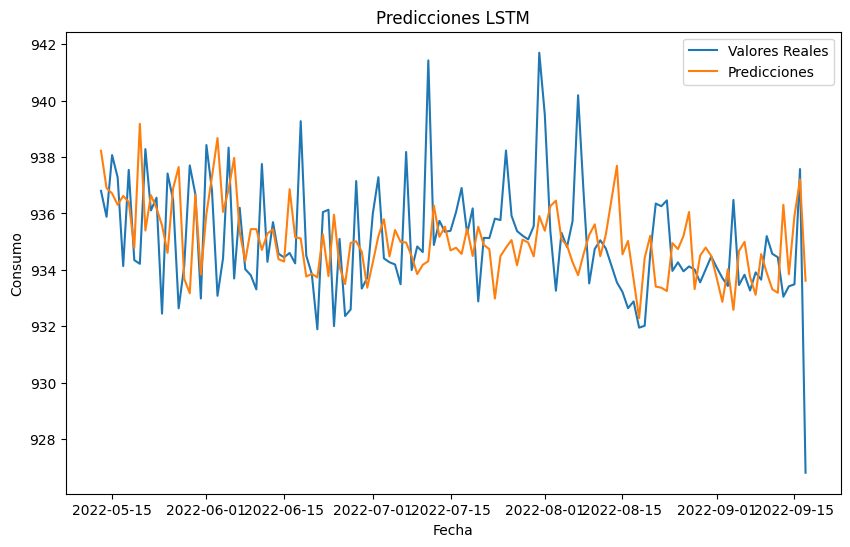

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates_ex2, scaler.inverse_transform(y_test_ex2.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates_ex2, y_pred_ex2, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss_ex2 = modeloAgrupado2.evaluate([X_train_seq2, X2_train_ext1, X2_train_ext2, X2_train_ext3, X2_train_ext4, X2_train_ext5, X2_train_ext6, X2_train_ext7, X2_train_ext8, X2_train_ext9, X2_train_ext10], y_train_ex2, verbose=0)
test_loss_ex2 = modeloAgrupado2.evaluate([X_test_seq2, X2_test_ext1,  X2_test_ext2,  X2_test_ext3,  X2_test_ext4,  X2_test_ext5,  X2_test_ext6,  X2_test_ext7,  X2_test_ext8,  X2_test_ext9,  X2_test_ext10], y_test_ex2, verbose=0)
print('Train Loss:', train_loss_ex2)
print('Test Loss:', test_loss_ex2)

Train Loss: 0.01158969011157751
Test Loss: 0.02284490317106247


##Datos del tercer cliente

Leemos el archivo .csv que contiene los datos del consumo del cliente

In [ ]:
df_cliente3 = pd.read_csv('/content/drive/MyDrive/DataLake_TFG/DatosClientes/ConsumoHorario_Cliente3.csv', sep=',')
df_cliente3.head()

,FechaHora,Consumo
0,2020-11-09 00:00:00,279.0
1,2020-11-09 01:00:00,96.0
2,2020-11-09 02:00:00,105.0
3,2020-11-09 03:00:00,105.0
4,2020-11-09 04:00:00,80.0


Convertimos las fechas de la columna "FechaHora" a su tipo correcto

In [ ]:
df_cliente3['FechaHora'] = pd.to_datetime(df_cliente3['FechaHora'])

###Datos originales

Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size3 = int(len(df_cliente3) * 0.8)
train_data3, test_data3 = df_cliente3[:train_size3], df_cliente3[train_size3:]

Escalamos la columna "Consumo" en train_data y en test_data para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data3['Consumo'] = scaler.fit_transform(train_data3[['Consumo']])
test_data3['Consumo'] = scaler.transform(test_data3[['Consumo']])

<ipython-input-7-eb3d52e5bf84>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data3['Consumo'] = scaler.fit_transform(train_data3[['Consumo']])
<ipython-input-7-eb3d52e5bf84>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data3['Consumo'] = scaler.transform(test_data3[['Consumo']])


Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM

In [ ]:
def create_sequences(data3, seq_length):
    X = []
    y = []
    for i in range(len(data3) - seq_length):
        X.append(data3['Consumo'].values[i:i+seq_length])
        y.append(data3['Consumo'].values[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train3, y_train3 = create_sequences(train_data3, seq_length)
X_test3, y_test3 = create_sequences(test_data3, seq_length)

Transformamos los conjuntos de datos X_train y X_test en un formato tridimensional adecuado para su uso

In [ ]:
X_train3 = np.reshape(X_train3, (X_train3.shape[0], seq_length, 1))
X_test3 = np.reshape(X_test3, (X_test3.shape[0], seq_length, 1))

model = Sequential(): Creamos una instancia del modelo secuencial. El modelo secuencial es una pila lineal de capas de red neuronal, donde cada capa se conecta directamente con la capa siguiente. Es uno de los tipos de modelos más comunes en Keras

model.add(LSTM(50, input_shape=(seq_length, 1))): Agregamos una capa LSTM (Long Short-Term Memory) al modelo. La capa LSTM es una capa recurrente especializada en el procesamiento de secuencias de datos. Recibe una secuencia de entrada de longitud seq_length y una dimensión de características de 1. En este caso, se configura con 50 unidades de memoria

model.add(Dense(1)): Agregamos una capa densa al modelo. Esta capa densa tiene una sola unidad, que representa la salida del modelo

model.compile(loss='mse', optimizer='adam'):  Compilamos el modelo utilizando la función de pérdida de error cuadrático medio (mse) y el optimizador Adam que es un algoritmo de optimización popular que se adapta dinámicamente a la tasa de aprendizaje durante el entrenamiento de la red.

In [ ]:
modeloCliente3 = Sequential()
modeloCliente3.add(LSTM(50, input_shape=(seq_length, 1)))
modeloCliente3.add(Dense(1))
modeloCliente3.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train, y_train) durante 10 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloCliente3.fit(X_train3, y_train3, epochs=10, batch_size=1)

Epoch 1/10
13012/13012 [==============================] - 46s 3ms/step - loss: 0.0066
Epoch 2/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0065
Epoch 3/10
13012/13012 [==============================] - 43s 3ms/step - loss: 0.0064
Epoch 4/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0064
Epoch 5/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0063
Epoch 6/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0063
Epoch 7/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0062
Epoch 8/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0062
Epoch 9/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0062
Epoch 10/10
13012/13012 [==============================] - 42s 3ms/step - loss: 0.0061


 Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred3 = modeloCliente3.predict(X_test3)
y_pred3 = scaler.inverse_transform(y_pred3)

102/102 [==============================] - 2s 4ms/step


Tomamos una columna de fechas del DataFrame test_data, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates3 = pd.to_datetime(test_data3['FechaHora'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

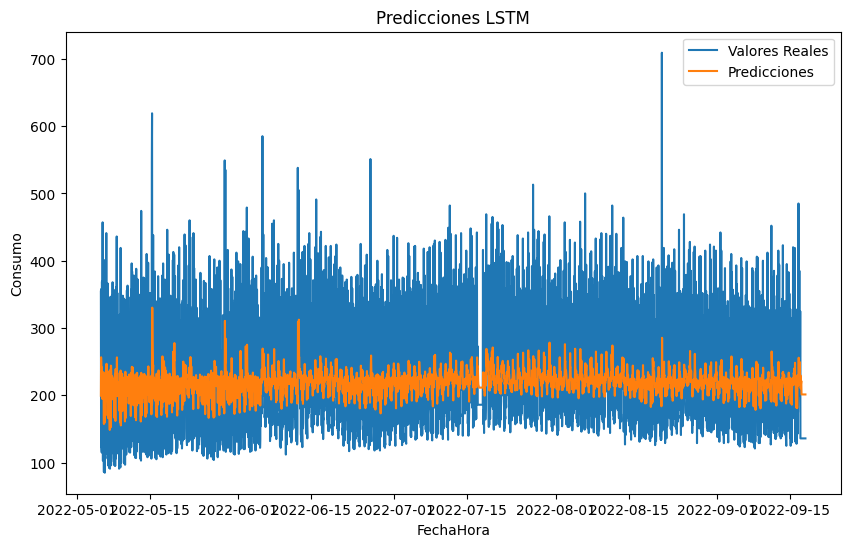

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates3, scaler.inverse_transform(y_test3.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates3, y_pred3, label='Predicciones')
plt.xlabel('FechaHora')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss3 = modeloCliente3.evaluate(X_train3, y_train3, verbose=0)
test_loss3 = modeloCliente3.evaluate(X_test3, y_test3, verbose=0)
print('Train Loss:', train_loss3)
print('Test Loss:', test_loss3)

Train Loss: 0.006023793946951628
Test Loss: 0.0025595426559448242


A partir de este punto los datos usados estarán agrupados por días, es decir, asignaremos a cada día el consumo total realizado en ese día y probaremos a añadir valirables externas para ver que efecto tienen en la predicción

###Datos agrupados con variables externas

Creamos un nueva columna "Fecha" que tendrá todas las fechas sin la parte horaria y agrupamos con la columna de consumo para tener el total de energía que se consumio ese día

In [ ]:
df_cliente3['fecha'] = df_cliente3['FechaHora'].dt.date
df_agrupado3 = df_cliente3.groupby('fecha')['Consumo'].sum().reset_index()
df_agrupado3.head()

,fecha,Consumo
0,2020-11-09,5174.0
1,2020-11-10,5006.0
2,2020-11-11,5095.0
3,2020-11-12,2280.0
4,2020-11-13,5116.0


Convertimos las fechas de la columna "fecha" a su tipo correcto

In [ ]:
df_agrupado3['fecha'] = pd.to_datetime(df_agrupado3['fecha'])

Juntamos los dataframe con los datos agrupados y las variables externas previamente preparadas usando de pivote la columna fecha, la cual debe coincidir en ambas tablas para se haga correctamente

In [ ]:
df_total3 = pd.merge(df_agrupado3, df_clima, on='fecha')
df_total3

,fecha,Consumo,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,5174.0,11.7,2.0,6.6,16.8,21.0,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,5006.0,9.6,0.0,3.6,15.6,28.0,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,5095.0,9.0,0.2,2.9,15.2,10.0,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,2280.0,9.6,0.0,3.3,15.8,10.0,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,5116.0,10.2,0.2,3.7,16.7,11.0,0.8,6.7,7.3,941.3,939.3
...,...,...,...,...,...,...,...,...,...,...,...,...
652,2022-09-13,5089.0,22.2,1.0,17.8,26.6,19.0,4.7,16.7,6.0,932.6,930.1
653,2022-09-14,5023.0,21.2,0.0,16.1,26.3,23.0,3.3,13.9,6.7,935.3,931.7
654,2022-09-15,5302.0,20.4,0.6,16.2,24.6,30.0,1.7,11.4,4.6,936.5,934.6
655,2022-09-16,5237.0,21.0,0.0,14.2,27.9,29.0,1.7,7.8,12.0,936.6,933.2


Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size_ex3 = int(len(df_total3) * 0.8)
train_data_ex3, test_data_ex3 = df_total3[:train_size_ex3], df_total3[train_size_ex3:]

Escalamos la columna "Consumo" y todas las variables externas que se van a utilizar en el modelo, en train_data_ex y en test_data_ex para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data_ex3['Consumo'] = scaler.fit_transform(train_data_ex3[['Consumo']])
train_data_ex3['tmed'] = scaler.fit_transform(train_data_ex3[['tmed']])
train_data_ex3['prec'] = scaler.fit_transform(train_data_ex3[['prec']])
train_data_ex3['tmin'] = scaler.fit_transform(train_data_ex3[['tmin']])
train_data_ex3['tmax'] = scaler.fit_transform(train_data_ex3[['tmax']])
train_data_ex3['dir'] = scaler.fit_transform(train_data_ex3[['dir']])
train_data_ex3['velmedia'] = scaler.fit_transform(train_data_ex3[['velmedia']])
train_data_ex3['racha'] = scaler.fit_transform(train_data_ex3[['racha']])
train_data_ex3['sol'] = scaler.fit_transform(train_data_ex3[['sol']])
train_data_ex3['presMax'] = scaler.fit_transform(train_data_ex3[['presMax']])
train_data_ex3['presMin'] = scaler.fit_transform(train_data_ex3[['presMin']])

test_data_ex3['Consumo'] = scaler.fit_transform(test_data_ex3[['Consumo']])
test_data_ex3['tmed'] = scaler.fit_transform(test_data_ex3[['tmed']])
test_data_ex3['prec'] = scaler.fit_transform(test_data_ex3[['prec']])
test_data_ex3['tmin'] = scaler.fit_transform(test_data_ex3[['tmin']])
test_data_ex3['tmax'] = scaler.fit_transform(test_data_ex3[['tmax']])
test_data_ex3['dir'] = scaler.fit_transform(test_data_ex3[['dir']])
test_data_ex3['velmedia'] = scaler.fit_transform(test_data_ex3[['velmedia']])
test_data_ex3['racha'] = scaler.fit_transform(test_data_ex3[['racha']])
test_data_ex3['sol'] = scaler.fit_transform(test_data_ex3[['sol']])
test_data_ex3['presMax'] = scaler.fit_transform(test_data_ex3[['presMax']])
test_data_ex3['presMin'] = scaler.fit_transform(test_data_ex3[['presMin']])

<ipython-input-17-92095d50d9c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex3['Consumo'] = scaler.fit_transform(train_data_ex3[['Consumo']])
<ipython-input-17-92095d50d9c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex3['tmed'] = scaler.fit_transform(train_data_ex3[['tmed']])
<ipython-input-17-92095d50d9c0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM con variables externas

In [ ]:
def create_sequences(data_ex3, seq_length):
    X_seq3 = []
    X3_ext1 = []
    X3_ext2 = []
    X3_ext3 = []
    X3_ext4 = []
    X3_ext5 = []
    X3_ext6 = []
    X3_ext7 = []
    X3_ext8 = []
    X3_ext9 = []
    X3_ext10 = []
    y3 = []
    for i in range(len(data_ex3) - seq_length):
        X_seq3.append(data_ex3['Consumo'].values[i:i+seq_length])
        X3_ext1.append(data_ex3['tmed'].values[i:i+seq_length])
        X3_ext2.append(data_ex3['prec'].values[i:i+seq_length])
        X3_ext3.append(data_ex3['tmin'].values[i:i+seq_length])
        X3_ext4.append(data_ex3['tmax'].values[i:i+seq_length])
        X3_ext5.append(data_ex3['dir'].values[i:i+seq_length])
        X3_ext6.append(data_ex3['velmedia'].values[i:i+seq_length])
        X3_ext7.append(data_ex3['racha'].values[i:i+seq_length])
        X3_ext8.append(data_ex3['sol'].values[i:i+seq_length])
        X3_ext9.append(data_ex3['presMax'].values[i:i+seq_length])
        X3_ext10.append(data_ex3['presMin'].values[i:i+seq_length])
        y3.append(data_ex3['Consumo'].values[i+seq_length])
    return np.array(X_seq3), np.array(X3_ext1), np.array(X3_ext2), np.array(X3_ext3), np.array(X3_ext4), np.array(X3_ext5), np.array(X3_ext6), np.array(X3_ext7), np.array(X3_ext8), np.array(X3_ext9), np.array(X3_ext10), np.array(y3)

seq_length = 5
X_train_seq3, X3_train_ext1, X3_train_ext2, X3_train_ext3, X3_train_ext4, X3_train_ext5, X3_train_ext6, X3_train_ext7, X3_train_ext8, X3_train_ext9, X3_train_ext10, y_train_ex3 = create_sequences(train_data_ex3, seq_length)
X_test_seq3, X3_test_ext1, X3_test_ext2,  X3_test_ext3,  X3_test_ext4,  X3_test_ext5,  X3_test_ext6,  X3_test_ext7,  X3_test_ext8,  X3_test_ext9,  X3_test_ext10, y_test_ex3 = create_sequences(test_data_ex3, seq_length)

Transformamos los conjuntos de datos X_train_seq y X_test_seq en un formato tridimensional adecuado para su uso

In [ ]:
X_train_seq3 = np.reshape(X_train_seq3, (X_train_seq3.shape[0], seq_length, 1))
X_test_seq3 = np.reshape(X_test_seq3, (X_test_seq3.shape[0], seq_length, 1))

Definimos 11 conjuntos de datos de entrada, cada uno representado por un objeto Input de Keras con la forma (seq_length, 1). Esto indica que cada secuencia de entrada tiene una longitud de seq_length y una dimensión de 1

Después, definimos una capa LSTM con 50 unidades para cada uno de los 11 conjuntos de entrada (11 LSTMs en total). Esto se hace mediante la llamada a LSTM(50) con cada uno de los objetos Input como entrada.

Luego, todas las salidas de las LSTMs (11 en total) se concatenan usando "keras.layers.concatenate". La salida concatenada resultante será una sola secuencia.

Después de la concatenación, se agrega una capa Dense con una sola unidad para producir la salida final.

Finalmente, se crea el modelo utilizando Model, definiendo los 11 objetos Input como entradas y el objeto Dense como salida. El modelo se compila utilizando la función de pérdida de error cuadrático medio ('mse') y el optimizador Adam ('adam') para el entrenamiento.

In [ ]:
seq_input3 = Input(shape=(seq_length, 1))
ext3_input1 = Input(shape=(seq_length, 1))
ext3_input2 = Input(shape=(seq_length, 1))
ext3_input3 = Input(shape=(seq_length, 1))
ext3_input4 = Input(shape=(seq_length, 1))
ext3_input5 = Input(shape=(seq_length, 1))
ext3_input6 = Input(shape=(seq_length, 1))
ext3_input7 = Input(shape=(seq_length, 1))
ext3_input8 = Input(shape=(seq_length, 1))
ext3_input9 = Input(shape=(seq_length, 1))
ext3_input10 = Input(shape=(seq_length, 1))
lstm_seq3 = LSTM(50)(seq_input3)
lstm3_ext1 = LSTM(50)(ext3_input1)
lstm3_ext2 = LSTM(50)(ext3_input2)
lstm3_ext3 = LSTM(50)(ext3_input3)
lstm3_ext4 = LSTM(50)(ext3_input4)
lstm3_ext5 = LSTM(50)(ext3_input5)
lstm3_ext6 = LSTM(50)(ext3_input6)
lstm3_ext7 = LSTM(50)(ext3_input7)
lstm3_ext8 = LSTM(50)(ext3_input8)
lstm3_ext9 = LSTM(50)(ext3_input9)
lstm3_ext10 = LSTM(50)(ext3_input10)
merged3 = keras.layers.concatenate([lstm_seq3, lstm3_ext1, lstm3_ext2, lstm3_ext3, lstm3_ext4, lstm3_ext5, lstm3_ext6, lstm3_ext7, lstm3_ext8, lstm3_ext9, lstm3_ext10])
output3 = Dense(1)(merged3)
modeloAgrupado3 = Model(inputs=[seq_input3, ext3_input1, ext3_input2, ext3_input3, ext3_input4, ext3_input5, ext3_input6, ext3_input7, ext3_input8, ext3_input9, ext3_input10], outputs=output3)
modeloAgrupado3.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train_seq, y_train_ex y todos los conjuntos de datos externos) durante 50 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloAgrupado3.fit([X_train_seq3, X3_train_ext1, X3_train_ext2, X3_train_ext3, X3_train_ext4, X3_train_ext5, X3_train_ext6, X3_train_ext7, X3_train_ext8, X3_train_ext9, X3_train_ext10], y_train_ex3, epochs=50, batch_size=1)

Epoch 1/50
520/520 [==============================] - 32s 22ms/step - loss: 0.0186
Epoch 2/50
520/520 [==============================] - 10s 18ms/step - loss: 0.0146
Epoch 3/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0141
Epoch 4/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0136
Epoch 5/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0134
Epoch 6/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0136
Epoch 7/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0134
Epoch 8/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0128
Epoch 9/50
520/520 [==============================] - 9s 17ms/step - loss: 0.0127
Epoch 10/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0128
Epoch 11/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0125
Epoch 12/50
520/520 [==============================] - 10s 19ms/step - loss: 0.0126
Ep

Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred_ex3 = modeloAgrupado3.predict([X_test_seq3, X3_test_ext1,  X3_test_ext2,  X3_test_ext3,  X3_test_ext4,  X3_test_ext5,  X3_test_ext6,  X3_test_ext7,  X3_test_ext8,  X3_test_ext9,  X3_test_ext10])
y_pred_ex3 = scaler.inverse_transform(y_pred_ex3)

4/4 [==============================] - 6s 10ms/step


Tomamos una columna de fechas del DataFrame test_data_ex, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates_ex3 = pd.to_datetime(test_data_ex3['fecha'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

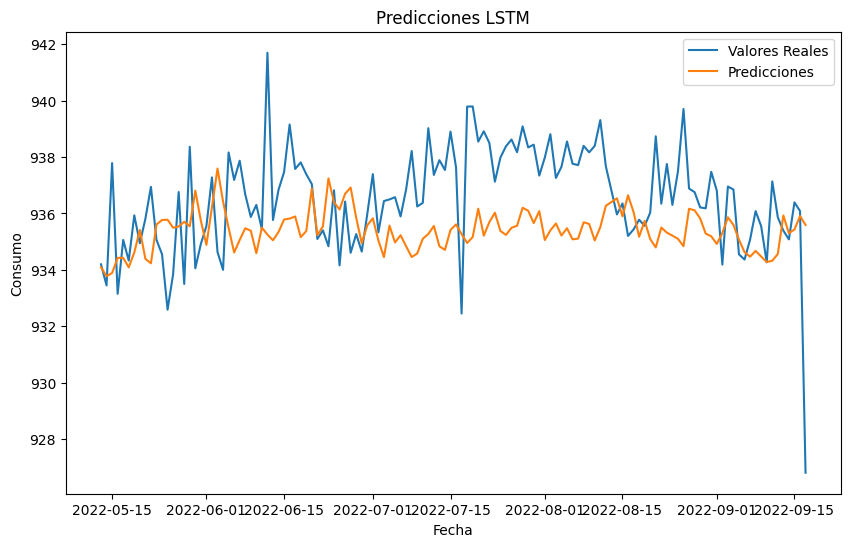

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates_ex3, scaler.inverse_transform(y_test_ex3.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates_ex3, y_pred_ex3, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss_ex3 = modeloAgrupado3.evaluate([X_train_seq3, X3_train_ext1, X3_train_ext2, X3_train_ext3, X3_train_ext4, X3_train_ext5, X3_train_ext6, X3_train_ext7, X3_train_ext8, X3_train_ext9, X3_train_ext10], y_train_ex3, verbose=0)
test_loss_ex3 = modeloAgrupado3.evaluate([X_test_seq3, X3_test_ext1, X3_test_ext2, X3_test_ext3, X3_test_ext4, X3_test_ext5, X3_test_ext6, X3_test_ext7, X3_test_ext8, X3_test_ext9, X3_test_ext10], y_test_ex3, verbose=0)
print('Train Loss:', train_loss_ex3)
print('Test Loss:', test_loss_ex3)

Train Loss: 0.010219702497124672
Test Loss: 0.02396448329091072


##Datos del cuarto cliente

Leemos el archivo .csv que contiene los datos del consumo del cliente

In [ ]:
df_cliente4 = pd.read_csv('/content/drive/MyDrive/DataLake_TFG/DatosClientes/ConsumoHorario_Cliente4.csv', sep=',')
df_cliente4.head()

,FechaHora,Consumo
0,2020-11-09 00:00:00,372.0
1,2020-11-09 01:00:00,314.0
2,2020-11-09 02:00:00,313.0
3,2020-11-09 03:00:00,293.0
4,2020-11-09 04:00:00,259.0


Convertimos las fechas de la columna "FechaHora" a su tipo correcto

In [ ]:
df_cliente4['FechaHora'] = pd.to_datetime(df_cliente4['FechaHora'])

###Datos originales

Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size4 = int(len(df_cliente4) * 0.8)
train_data4, test_data4 = df_cliente4[:train_size4], df_cliente4[train_size4:]

Escalamos la columna "Consumo" en train_data y en test_data para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data4['Consumo'] = scaler.fit_transform(train_data4[['Consumo']])
test_data4['Consumo'] = scaler.transform(test_data4[['Consumo']])

<ipython-input-17-85668509c9e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data4['Consumo'] = scaler.fit_transform(train_data4[['Consumo']])
<ipython-input-17-85668509c9e0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data4['Consumo'] = scaler.transform(test_data4[['Consumo']])


Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM

In [ ]:
def create_sequences(data4, seq_length):
    X = []
    y = []
    for i in range(len(data4) - seq_length):
        X.append(data4['Consumo'].values[i:i+seq_length])
        y.append(data4['Consumo'].values[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train4, y_train4 = create_sequences(train_data4, seq_length)
X_test4, y_test4 = create_sequences(test_data4, seq_length)

Transformamos los conjuntos de datos X_train y X_test en un formato tridimensional adecuado para su uso

In [ ]:
X_train4 = np.reshape(X_train4, (X_train4.shape[0], seq_length, 1))
X_test4 = np.reshape(X_test4, (X_test4.shape[0], seq_length, 1))

model = Sequential(): Creamos una instancia del modelo secuencial. El modelo secuencial es una pila lineal de capas de red neuronal, donde cada capa se conecta directamente con la capa siguiente. Es uno de los tipos de modelos más comunes en Keras

model.add(LSTM(50, input_shape=(seq_length, 1))): Agregamos una capa LSTM (Long Short-Term Memory) al modelo. La capa LSTM es una capa recurrente especializada en el procesamiento de secuencias de datos. Recibe una secuencia de entrada de longitud seq_length y una dimensión de características de 1. En este caso, se configura con 50 unidades de memoria

model.add(Dense(1)): Agregamos una capa densa al modelo. Esta capa densa tiene una sola unidad, que representa la salida del modelo

model.compile(loss='mse', optimizer='adam'):  Compilamos el modelo utilizando la función de pérdida de error cuadrático medio (mse) y el optimizador Adam que es un algoritmo de optimización popular que se adapta dinámicamente a la tasa de aprendizaje durante el entrenamiento de la red.

In [ ]:
modeloCliente4 = Sequential()
modeloCliente4.add(LSTM(50, input_shape=(seq_length, 1)))
modeloCliente4.add(Dense(1))
modeloCliente4.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train, y_train) durante 10 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloCliente4.fit(X_train4, y_train4, epochs=10, batch_size=1)

Epoch 1/10
13012/13012 [==============================] - 65s 5ms/step - loss: 0.0068
Epoch 2/10
13012/13012 [==============================] - 64s 5ms/step - loss: 0.0066
Epoch 3/10
13012/13012 [==============================] - 64s 5ms/step - loss: 0.0065
Epoch 4/10
13012/13012 [==============================] - 62s 5ms/step - loss: 0.0065
Epoch 5/10
13012/13012 [==============================] - 58s 4ms/step - loss: 0.0064
Epoch 6/10
13012/13012 [==============================] - 60s 5ms/step - loss: 0.0064
Epoch 7/10
13012/13012 [==============================] - 59s 5ms/step - loss: 0.0064
Epoch 8/10
13012/13012 [==============================] - 60s 5ms/step - loss: 0.0064
Epoch 9/10
13012/13012 [==============================] - 61s 5ms/step - loss: 0.0064
Epoch 10/10
13012/13012 [==============================] - 62s 5ms/step - loss: 0.0064


 Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred4 = modeloCliente4.predict(X_test4)
y_pred4 = scaler.inverse_transform(y_pred4)

102/102 [==============================] - 1s 3ms/step


Tomamos una columna de fechas del DataFrame test_data, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates4 = pd.to_datetime(test_data4['FechaHora'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

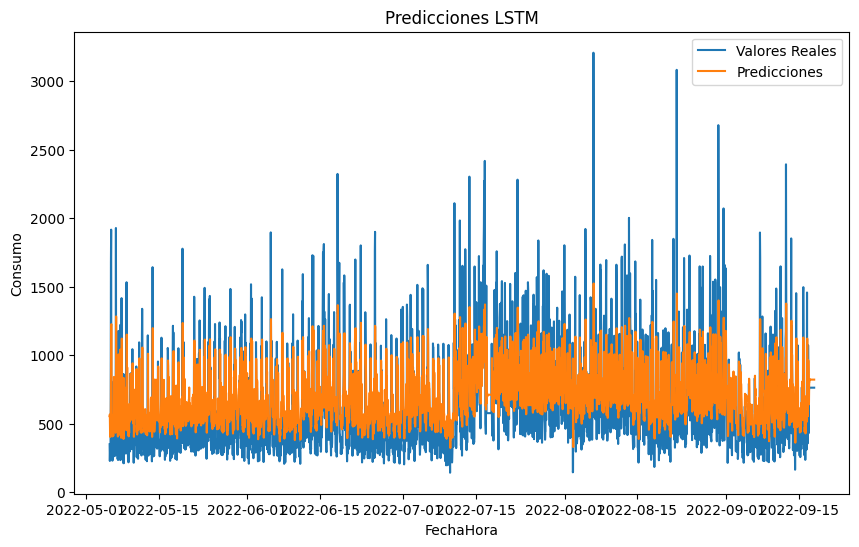

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates4, scaler.inverse_transform(y_test4.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates4, y_pred4, label='Predicciones')
plt.xlabel('FechaHora')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss4 = modeloCliente4.evaluate(X_train4, y_train4, verbose=0)
test_loss4 = modeloCliente4.evaluate(X_test4, y_test4, verbose=0)
print('Train Loss:', train_loss4)
print('Test Loss:', test_loss4)

Train Loss: 0.006404516287147999
Test Loss: 0.004129309672862291


A partir de este punto los datos usados estarán agrupados por días, es decir, asignaremos a cada día el consumo total realizado en ese día y probaremos a añadir valirables externas para ver que efecto tienen en la predicción

###Datos agrupados con variables externas

Creamos un nueva columna "Fecha" que tendrá todas las fechas sin la parte horaria y agrupamos con la columna de consumo para tener el total de energía que se consumio ese día

In [ ]:
df_cliente4['fecha'] = df_cliente4['FechaHora'].dt.date
df_agrupado4 = df_cliente4.groupby('fecha')['Consumo'].sum().reset_index()
df_agrupado4.head()

,fecha,Consumo
0,2020-11-09,18283.0
1,2020-11-10,14420.0
2,2020-11-11,16805.0
3,2020-11-12,9528.0
4,2020-11-13,17563.0


Convertimos las fechas de la columna "fecha" a su tipo correcto

In [ ]:
df_agrupado4['fecha'] = pd.to_datetime(df_agrupado4['fecha'])

Juntamos los dataframe con los datos agrupados y las variables externas previamente preparadas usando de pivote la columna fecha, la cual debe coincidir en ambas tablas para se haga correctamente

In [ ]:
df_total4 = pd.merge(df_agrupado4, df_clima, on='fecha')
df_total4

,fecha,Consumo,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,18283.0,11.7,2.0,6.6,16.8,21.0,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,14420.0,9.6,0.0,3.6,15.6,28.0,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,16805.0,9.0,0.2,2.9,15.2,10.0,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,9528.0,9.6,0.0,3.3,15.8,10.0,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,17563.0,10.2,0.2,3.7,16.7,11.0,0.8,6.7,7.3,941.3,939.3
...,...,...,...,...,...,...,...,...,...,...,...,...
652,2022-09-13,14987.0,22.2,1.0,17.8,26.6,19.0,4.7,16.7,6.0,932.6,930.1
653,2022-09-14,11954.0,21.2,0.0,16.1,26.3,23.0,3.3,13.9,6.7,935.3,931.7
654,2022-09-15,12673.0,20.4,0.6,16.2,24.6,30.0,1.7,11.4,4.6,936.5,934.6
655,2022-09-16,12329.0,21.0,0.0,14.2,27.9,29.0,1.7,7.8,12.0,936.6,933.2


Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size_ex4 = int(len(df_total4) * 0.8)
train_data_ex4, test_data_ex4 = df_total4[:train_size_ex4], df_total4[train_size_ex4:]

Escalamos la columna "Consumo" y todas las variables externas que se van a utilizar en el modelo, en train_data_ex y en test_data_ex para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data_ex4['Consumo'] = scaler.fit_transform(train_data_ex4[['Consumo']])
train_data_ex4['tmed'] = scaler.fit_transform(train_data_ex4[['tmed']])
train_data_ex4['prec'] = scaler.fit_transform(train_data_ex4[['prec']])
train_data_ex4['tmin'] = scaler.fit_transform(train_data_ex4[['tmin']])
train_data_ex4['tmax'] = scaler.fit_transform(train_data_ex4[['tmax']])
train_data_ex4['dir'] = scaler.fit_transform(train_data_ex4[['dir']])
train_data_ex4['velmedia'] = scaler.fit_transform(train_data_ex4[['velmedia']])
train_data_ex4['racha'] = scaler.fit_transform(train_data_ex4[['racha']])
train_data_ex4['sol'] = scaler.fit_transform(train_data_ex4[['sol']])
train_data_ex4['presMax'] = scaler.fit_transform(train_data_ex4[['presMax']])
train_data_ex4['presMin'] = scaler.fit_transform(train_data_ex4[['presMin']])

test_data_ex4['Consumo'] = scaler.fit_transform(test_data_ex4[['Consumo']])
test_data_ex4['tmed'] = scaler.fit_transform(test_data_ex4[['tmed']])
test_data_ex4['prec'] = scaler.fit_transform(test_data_ex4[['prec']])
test_data_ex4['tmin'] = scaler.fit_transform(test_data_ex4[['tmin']])
test_data_ex4['tmax'] = scaler.fit_transform(test_data_ex4[['tmax']])
test_data_ex4['dir'] = scaler.fit_transform(test_data_ex4[['dir']])
test_data_ex4['velmedia'] = scaler.fit_transform(test_data_ex4[['velmedia']])
test_data_ex4['racha'] = scaler.fit_transform(test_data_ex4[['racha']])
test_data_ex4['sol'] = scaler.fit_transform(test_data_ex4[['sol']])
test_data_ex4['presMax'] = scaler.fit_transform(test_data_ex4[['presMax']])
test_data_ex4['presMin'] = scaler.fit_transform(test_data_ex4[['presMin']])

<ipython-input-16-0d2647cdee98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex4['Consumo'] = scaler.fit_transform(train_data_ex4[['Consumo']])
<ipython-input-16-0d2647cdee98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex4['tmed'] = scaler.fit_transform(train_data_ex4[['tmed']])
<ipython-input-16-0d2647cdee98>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM con variables externas

In [ ]:
def create_sequences(data_ex4, seq_length):
    X_seq4 = []
    X4_ext1 = []
    X4_ext2 = []
    X4_ext3 = []
    X4_ext4 = []
    X4_ext5 = []
    X4_ext6 = []
    X4_ext7 = []
    X4_ext8 = []
    X4_ext9 = []
    X4_ext10 = []
    y4 = []
    for i in range(len(data_ex4) - seq_length):
        X_seq4.append(data_ex4['Consumo'].values[i:i+seq_length])
        X4_ext1.append(data_ex4['tmed'].values[i:i+seq_length])
        X4_ext2.append(data_ex4['prec'].values[i:i+seq_length])
        X4_ext3.append(data_ex4['tmin'].values[i:i+seq_length])
        X4_ext4.append(data_ex4['tmax'].values[i:i+seq_length])
        X4_ext5.append(data_ex4['dir'].values[i:i+seq_length])
        X4_ext6.append(data_ex4['velmedia'].values[i:i+seq_length])
        X4_ext7.append(data_ex4['racha'].values[i:i+seq_length])
        X4_ext8.append(data_ex4['sol'].values[i:i+seq_length])
        X4_ext9.append(data_ex4['presMax'].values[i:i+seq_length])
        X4_ext10.append(data_ex4['presMin'].values[i:i+seq_length])
        y4.append(data_ex4['Consumo'].values[i+seq_length])
    return np.array(X_seq4), np.array(X4_ext1), np.array(X4_ext2), np.array(X4_ext3), np.array(X4_ext4), np.array(X4_ext5), np.array(X4_ext6), np.array(X4_ext7), np.array(X4_ext8), np.array(X4_ext9), np.array(X4_ext10), np.array(y4)

seq_length = 5
X_train_seq4, X4_train_ext1, X4_train_ext2, X4_train_ext3, X4_train_ext4, X4_train_ext5, X4_train_ext6, X4_train_ext7, X4_train_ext8, X4_train_ext9, X4_train_ext10, y_train_ex4 = create_sequences(train_data_ex4, seq_length)
X_test_seq4, X4_test_ext1, X4_test_ext2, X4_test_ext3, X4_test_ext4, X4_test_ext5, X4_test_ext6, X4_test_ext7, X4_test_ext8, X4_test_ext9, X4_test_ext10, y_test_ex4 = create_sequences(test_data_ex4, seq_length)

Transformamos los conjuntos de datos X_train_seq y X_test_seq en un formato tridimensional adecuado para su uso

In [ ]:
X_train_seq4 = np.reshape(X_train_seq4, (X_train_seq4.shape[0], seq_length, 1))
X_test_seq4 = np.reshape(X_test_seq4, (X_test_seq4.shape[0], seq_length, 1))

Definimos 11 conjuntos de datos de entrada, cada uno representado por un objeto Input de Keras con la forma (seq_length, 1). Esto indica que cada secuencia de entrada tiene una longitud de seq_length y una dimensión de 1

Después, definimos una capa LSTM con 50 unidades para cada uno de los 11 conjuntos de entrada (11 LSTMs en total). Esto se hace mediante la llamada a LSTM(50) con cada uno de los objetos Input como entrada.

Luego, todas las salidas de las LSTMs (11 en total) se concatenan usando "keras.layers.concatenate". La salida concatenada resultante será una sola secuencia.

Después de la concatenación, se agrega una capa Dense con una sola unidad para producir la salida final.

Finalmente, se crea el modelo utilizando Model, definiendo los 11 objetos Input como entradas y el objeto Dense como salida. El modelo se compila utilizando la función de pérdida de error cuadrático medio ('mse') y el optimizador Adam ('adam') para el entrenamiento.

In [ ]:
seq_input4 = Input(shape=(seq_length, 1))
ext4_input1 = Input(shape=(seq_length, 1))
ext4_input2 = Input(shape=(seq_length, 1))
ext4_input3 = Input(shape=(seq_length, 1))
ext4_input4 = Input(shape=(seq_length, 1))
ext4_input5 = Input(shape=(seq_length, 1))
ext4_input6 = Input(shape=(seq_length, 1))
ext4_input7 = Input(shape=(seq_length, 1))
ext4_input8 = Input(shape=(seq_length, 1))
ext4_input9 = Input(shape=(seq_length, 1))
ext4_input10 = Input(shape=(seq_length, 1))
lstm_seq4 = LSTM(50)(seq_input4)
lstm4_ext1 = LSTM(50)(ext4_input1)
lstm4_ext2 = LSTM(50)(ext4_input2)
lstm4_ext3 = LSTM(50)(ext4_input3)
lstm4_ext4 = LSTM(50)(ext4_input4)
lstm4_ext5 = LSTM(50)(ext4_input5)
lstm4_ext6 = LSTM(50)(ext4_input6)
lstm4_ext7 = LSTM(50)(ext4_input7)
lstm4_ext8 = LSTM(50)(ext4_input8)
lstm4_ext9 = LSTM(50)(ext4_input9)
lstm4_ext10 = LSTM(50)(ext4_input10)
merged4 = keras.layers.concatenate([lstm_seq4, lstm4_ext1, lstm4_ext2, lstm4_ext3, lstm4_ext4, lstm4_ext5, lstm4_ext6, lstm4_ext7, lstm4_ext8, lstm4_ext9, lstm4_ext10])
output4 = Dense(1)(merged4)
modeloAgrupado4 = Model(inputs=[seq_input4, ext4_input1, ext4_input2, ext4_input3, ext4_input4, ext4_input5, ext4_input6, ext4_input7, ext4_input8, ext4_input9, ext4_input10], outputs=output4)
modeloAgrupado4.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train_seq, y_train_ex y todos los conjuntos de datos externos) durante 50 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloAgrupado4.fit([X_train_seq4, X4_train_ext1, X4_train_ext2, X4_train_ext3, X4_train_ext4, X4_train_ext5, X4_train_ext6, X4_train_ext7, X4_train_ext8, X4_train_ext9, X4_train_ext10], y_train_ex4, epochs=50, batch_size=1)

Epoch 1/50
520/520 [==============================] - 45s 35ms/step - loss: 0.0135
Epoch 2/50
520/520 [==============================] - 13s 26ms/step - loss: 0.0117
Epoch 3/50
520/520 [==============================] - 17s 32ms/step - loss: 0.0117
Epoch 4/50
520/520 [==============================] - 19s 36ms/step - loss: 0.0109
Epoch 5/50
520/520 [==============================] - 20s 39ms/step - loss: 0.0110
Epoch 6/50
520/520 [==============================] - 16s 31ms/step - loss: 0.0109
Epoch 7/50
520/520 [==============================] - 18s 34ms/step - loss: 0.0109
Epoch 8/50
520/520 [==============================] - 18s 36ms/step - loss: 0.0107
Epoch 9/50
520/520 [==============================] - 15s 29ms/step - loss: 0.0106
Epoch 10/50
520/520 [==============================] - 11s 21ms/step - loss: 0.0105
Epoch 11/50
520/520 [==============================] - 10s 20ms/step - loss: 0.0107
Epoch 12/50
520/520 [==============================] - 9s 17ms/step - loss: 0.0102
Ep

Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred_ex4 = modeloAgrupado4.predict([X_test_seq4, X4_test_ext1,  X4_test_ext2,  X4_test_ext3,  X4_test_ext4,  X4_test_ext5,  X4_test_ext6,  X4_test_ext7,  X4_test_ext8,  X4_test_ext9,  X4_test_ext10])
y_pred_ex4 = scaler.inverse_transform(y_pred_ex4)

4/4 [==============================] - 4s 9ms/step


Tomamos una columna de fechas del DataFrame test_data_ex, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates_ex4 = pd.to_datetime(test_data_ex4['fecha'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

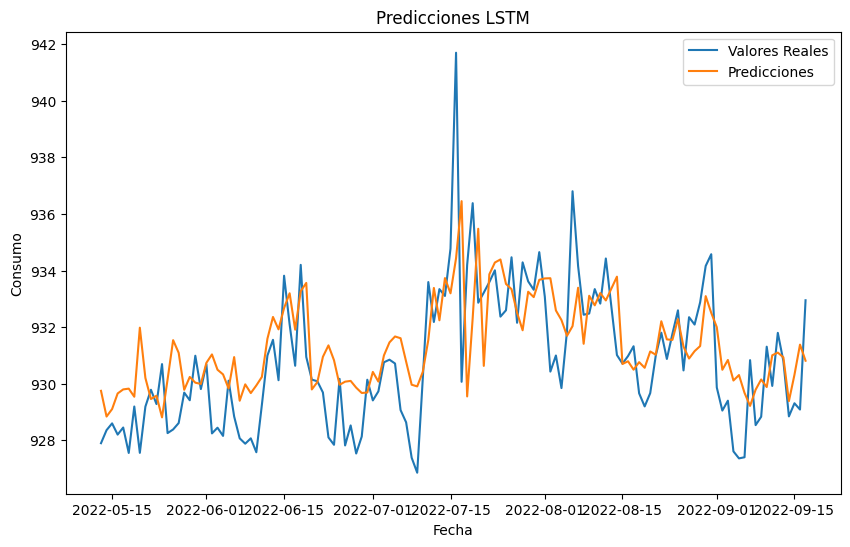

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates_ex4, scaler.inverse_transform(y_test_ex4.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates_ex4, y_pred_ex4, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss_ex4 = modeloAgrupado4.evaluate([X_train_seq4, X4_train_ext1, X4_train_ext2, X4_train_ext3, X4_train_ext4, X4_train_ext5, X4_train_ext6, X4_train_ext7, X4_train_ext8, X4_train_ext9, X4_train_ext10], y_train_ex4, verbose=0)
test_loss_ex4 = modeloAgrupado4.evaluate([X_test_seq4, X4_test_ext1, X4_test_ext2, X4_test_ext3, X4_test_ext4, X4_test_ext5, X4_test_ext6, X4_test_ext7, X4_test_ext8, X4_test_ext9, X4_test_ext10], y_test_ex4, verbose=0)
print('Train Loss:', train_loss_ex4)
print('Test Loss:', test_loss_ex4)

Train Loss: 0.008929220028221607
Test Loss: 0.016634246334433556


##Datos del quinto cliente

Leemos el archivo .csv que contiene los datos del consumo del cliente

In [ ]:
df_cliente5 = pd.read_csv('/content/drive/MyDrive/DataLake_TFG/DatosClientes/ConsumoHorario_Cliente5.csv', sep=',')
df_cliente5.head()

,FechaHora,Consumo
0,2020-11-09 00:00:00,69.0
1,2020-11-09 01:00:00,57.0
2,2020-11-09 02:00:00,43.0
3,2020-11-09 03:00:00,40.0
4,2020-11-09 04:00:00,35.0


Convertimos las fechas de la columna "FechaHora" a su tipo correcto

In [ ]:
df_cliente5['FechaHora'] = pd.to_datetime(df_cliente5['FechaHora'])

###Datos originales

Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size5 = int(len(df_cliente5) * 0.8)
train_data5, test_data5 = df_cliente5[:train_size5], df_cliente5[train_size5:]

Escalamos la columna "Consumo" en train_data y en test_data para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data5['Consumo'] = scaler.fit_transform(train_data5[['Consumo']])
test_data5['Consumo'] = scaler.transform(test_data5[['Consumo']])

<ipython-input-7-987e5ae1821e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data5['Consumo'] = scaler.fit_transform(train_data5[['Consumo']])
<ipython-input-7-987e5ae1821e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data5['Consumo'] = scaler.transform(test_data5[['Consumo']])


Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM

In [ ]:
def create_sequences(data5, seq_length):
    X = []
    y = []
    for i in range(len(data5) - seq_length):
        X.append(data5['Consumo'].values[i:i+seq_length])
        y.append(data5['Consumo'].values[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train5, y_train5 = create_sequences(train_data5, seq_length)
X_test5, y_test5 = create_sequences(test_data5, seq_length)

Transformamos los conjuntos de datos X_train y X_test en un formato tridimensional adecuado para su uso

In [ ]:
X_train5 = np.reshape(X_train5, (X_train5.shape[0], seq_length, 1))
X_test5 = np.reshape(X_test5, (X_test5.shape[0], seq_length, 1))

model = Sequential(): Creamos una instancia del modelo secuencial. El modelo secuencial es una pila lineal de capas de red neuronal, donde cada capa se conecta directamente con la capa siguiente. Es uno de los tipos de modelos más comunes en Keras

model.add(LSTM(50, input_shape=(seq_length, 1))): Agregamos una capa LSTM (Long Short-Term Memory) al modelo. La capa LSTM es una capa recurrente especializada en el procesamiento de secuencias de datos. Recibe una secuencia de entrada de longitud seq_length y una dimensión de características de 1. En este caso, se configura con 50 unidades de memoria

model.add(Dense(1)): Agregamos una capa densa al modelo. Esta capa densa tiene una sola unidad, que representa la salida del modelo

model.compile(loss='mse', optimizer='adam'):  Compilamos el modelo utilizando la función de pérdida de error cuadrático medio (mse) y el optimizador Adam que es un algoritmo de optimización popular que se adapta dinámicamente a la tasa de aprendizaje durante el entrenamiento de la red.

In [ ]:
modeloCliente5 = Sequential()
modeloCliente5.add(LSTM(50, input_shape=(seq_length, 1)))
modeloCliente5.add(Dense(1))
modeloCliente5.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train, y_train) durante 10 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloCliente5.fit(X_train5, y_train5, epochs=10, batch_size=1)

Epoch 1/10
13012/13012 [==============================] - 54s 4ms/step - loss: 0.0047
Epoch 2/10
13012/13012 [==============================] - 51s 4ms/step - loss: 0.0043
Epoch 3/10
13012/13012 [==============================] - 55s 4ms/step - loss: 0.0042
Epoch 4/10
13012/13012 [==============================] - 54s 4ms/step - loss: 0.0041
Epoch 5/10
13012/13012 [==============================] - 52s 4ms/step - loss: 0.0041
Epoch 6/10
13012/13012 [==============================] - 52s 4ms/step - loss: 0.0040
Epoch 7/10
13012/13012 [==============================] - 54s 4ms/step - loss: 0.0040
Epoch 8/10
13012/13012 [==============================] - 51s 4ms/step - loss: 0.0040
Epoch 9/10
13012/13012 [==============================] - 53s 4ms/step - loss: 0.0040
Epoch 10/10
13012/13012 [==============================] - 54s 4ms/step - loss: 0.0039


 Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred5 = modeloCliente5.predict(X_test5)
y_pred5 = scaler.inverse_transform(y_pred5)

102/102 [==============================] - 2s 6ms/step


Tomamos una columna de fechas del DataFrame test_data, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates5 = pd.to_datetime(test_data5['FechaHora'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

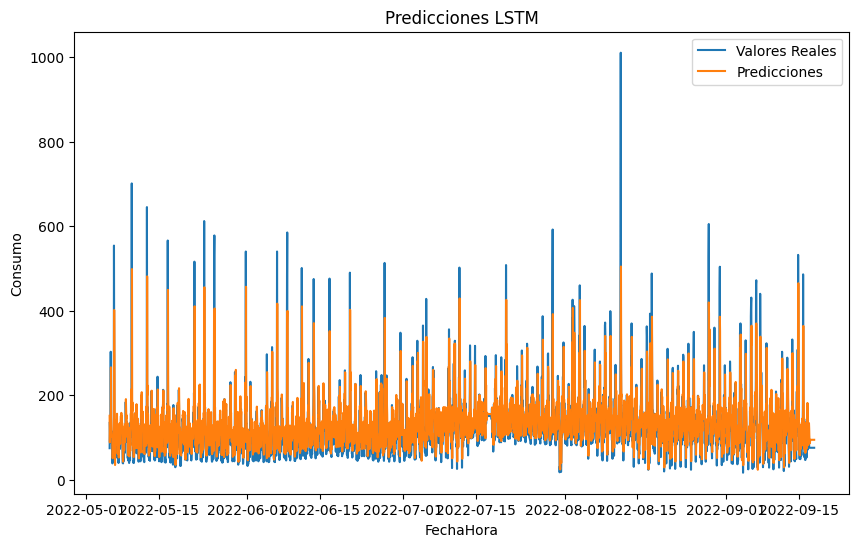

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates5, scaler.inverse_transform(y_test5.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates5, y_pred5, label='Predicciones')
plt.xlabel('FechaHora')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss5 = modeloCliente5.evaluate(X_train5, y_train5, verbose=0)
test_loss5 = modeloCliente5.evaluate(X_test5, y_test5, verbose=0)
print('Train Loss:', train_loss5)
print('Test Loss:', test_loss5)

Train Loss: 0.003966428339481354
Test Loss: 0.0016959105851128697


A partir de este punto los datos usados estarán agrupados por días, es decir, asignaremos a cada día el consumo total realizado en ese día y probaremos a añadir valirables externas para ver que efecto tienen en la predicción

###Datos agrupados con variables externas

Creamos un nueva columna "Fecha" que tendrá todas las fechas sin la parte horaria y agrupamos con la columna de consumo para tener el total de energía que se consumio ese día

In [ ]:
df_cliente5['fecha'] = df_cliente5['FechaHora'].dt.date
df_agrupado5 = df_cliente5.groupby('fecha')['Consumo'].sum().reset_index()
df_agrupado5.head()

,fecha,Consumo
0,2020-11-09,4594.0
1,2020-11-10,4106.0
2,2020-11-11,3332.0
3,2020-11-12,3456.0
4,2020-11-13,3928.0


Convertimos las fechas de la columna "fecha" a su tipo correcto

In [ ]:
df_agrupado5['fecha'] = pd.to_datetime(df_agrupado5['fecha'])

Juntamos los dataframe con los datos agrupados y las variables externas previamente preparadas usando de pivote la columna fecha, la cual debe coincidir en ambas tablas para se haga correctamente

In [ ]:
df_total5 = pd.merge(df_agrupado5, df_clima, on='fecha')
df_total5

,fecha,Consumo,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,4594.0,11.7,2.0,6.6,16.8,21.0,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,4106.0,9.6,0.0,3.6,15.6,28.0,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,3332.0,9.0,0.2,2.9,15.2,10.0,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,3456.0,9.6,0.0,3.3,15.8,10.0,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,3928.0,10.2,0.2,3.7,16.7,11.0,0.8,6.7,7.3,941.3,939.3
...,...,...,...,...,...,...,...,...,...,...,...,...
652,2022-09-13,2874.0,22.2,1.0,17.8,26.6,19.0,4.7,16.7,6.0,932.6,930.1
653,2022-09-14,3257.0,21.2,0.0,16.1,26.3,23.0,3.3,13.9,6.7,935.3,931.7
654,2022-09-15,2668.0,20.4,0.6,16.2,24.6,30.0,1.7,11.4,4.6,936.5,934.6
655,2022-09-16,2096.0,21.0,0.0,14.2,27.9,29.0,1.7,7.8,12.0,936.6,933.2


Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size_ex5 = int(len(df_total5) * 0.8)
train_data_ex5, test_data_ex5 = df_total5[:train_size_ex5], df_total5[train_size_ex5:]

Escalamos la columna "Consumo" y todas las variables externas que se van a utilizar en el modelo, en train_data_ex y en test_data_ex para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data_ex5['Consumo'] = scaler.fit_transform(train_data_ex5[['Consumo']])
train_data_ex5['tmed'] = scaler.fit_transform(train_data_ex5[['tmed']])
train_data_ex5['prec'] = scaler.fit_transform(train_data_ex5[['prec']])
train_data_ex5['tmin'] = scaler.fit_transform(train_data_ex5[['tmin']])
train_data_ex5['tmax'] = scaler.fit_transform(train_data_ex5[['tmax']])
train_data_ex5['dir'] = scaler.fit_transform(train_data_ex5[['dir']])
train_data_ex5['velmedia'] = scaler.fit_transform(train_data_ex5[['velmedia']])
train_data_ex5['racha'] = scaler.fit_transform(train_data_ex5[['racha']])
train_data_ex5['sol'] = scaler.fit_transform(train_data_ex5[['sol']])
train_data_ex5['presMax'] = scaler.fit_transform(train_data_ex5[['presMax']])
train_data_ex5['presMin'] = scaler.fit_transform(train_data_ex5[['presMin']])

test_data_ex5['Consumo'] = scaler.fit_transform(test_data_ex5[['Consumo']])
test_data_ex5['tmed'] = scaler.fit_transform(test_data_ex5[['tmed']])
test_data_ex5['prec'] = scaler.fit_transform(test_data_ex5[['prec']])
test_data_ex5['tmin'] = scaler.fit_transform(test_data_ex5[['tmin']])
test_data_ex5['tmax'] = scaler.fit_transform(test_data_ex5[['tmax']])
test_data_ex5['dir'] = scaler.fit_transform(test_data_ex5[['dir']])
test_data_ex5['velmedia'] = scaler.fit_transform(test_data_ex5[['velmedia']])
test_data_ex5['racha'] = scaler.fit_transform(test_data_ex5[['racha']])
test_data_ex5['sol'] = scaler.fit_transform(test_data_ex5[['sol']])
test_data_ex5['presMax'] = scaler.fit_transform(test_data_ex5[['presMax']])
test_data_ex5['presMin'] = scaler.fit_transform(test_data_ex5[['presMin']])

<ipython-input-16-8384ed799fed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex5['Consumo'] = scaler.fit_transform(train_data_ex5[['Consumo']])
<ipython-input-16-8384ed799fed>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_ex5['tmed'] = scaler.fit_transform(train_data_ex5[['tmed']])
<ipython-input-16-8384ed799fed>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM con variables externas

In [ ]:
def create_sequences(data_ex5, seq_length):
    X_seq5 = []
    X5_ext1 = []
    X5_ext2 = []
    X5_ext3 = []
    X5_ext4 = []
    X5_ext5 = []
    X5_ext6 = []
    X5_ext7 = []
    X5_ext8 = []
    X5_ext9 = []
    X5_ext10 = []
    y5 = []
    for i in range(len(data_ex5) - seq_length):
        X_seq5.append(data_ex5['Consumo'].values[i:i+seq_length])
        X5_ext1.append(data_ex5['tmed'].values[i:i+seq_length])
        X5_ext2.append(data_ex5['prec'].values[i:i+seq_length])
        X5_ext3.append(data_ex5['tmin'].values[i:i+seq_length])
        X5_ext4.append(data_ex5['tmax'].values[i:i+seq_length])
        X5_ext5.append(data_ex5['dir'].values[i:i+seq_length])
        X5_ext6.append(data_ex5['velmedia'].values[i:i+seq_length])
        X5_ext7.append(data_ex5['racha'].values[i:i+seq_length])
        X5_ext8.append(data_ex5['sol'].values[i:i+seq_length])
        X5_ext9.append(data_ex5['presMax'].values[i:i+seq_length])
        X5_ext10.append(data_ex5['presMin'].values[i:i+seq_length])
        y5.append(data_ex5['Consumo'].values[i+seq_length])
    return np.array(X_seq5), np.array(X5_ext1), np.array(X5_ext2), np.array(X5_ext3), np.array(X5_ext4), np.array(X5_ext5), np.array(X5_ext6), np.array(X5_ext7), np.array(X5_ext8), np.array(X5_ext9), np.array(X5_ext10), np.array(y5)

seq_length = 5
X_train_seq5, X5_train_ext1, X5_train_ext2, X5_train_ext3, X5_train_ext4, X5_train_ext5, X5_train_ext6, X5_train_ext7, X5_train_ext8, X5_train_ext9, X5_train_ext10, y_train_ex5 = create_sequences(train_data_ex5, seq_length)
X_test_seq5, X5_test_ext1, X5_test_ext2, X5_test_ext3, X5_test_ext4, X5_test_ext5, X5_test_ext6, X5_test_ext7, X5_test_ext8, X5_test_ext9, X5_test_ext10, y_test_ex5 = create_sequences(test_data_ex5, seq_length)

Transformamos los conjuntos de datos X_train_seq y X_test_seq en un formato tridimensional adecuado para su uso

In [ ]:
X_train_seq5 = np.reshape(X_train_seq5, (X_train_seq5.shape[0], seq_length, 1))
X_test_seq5 = np.reshape(X_test_seq5, (X_test_seq5.shape[0], seq_length, 1))

Definimos 11 conjuntos de datos de entrada, cada uno representado por un objeto Input de Keras con la forma (seq_length, 1). Esto indica que cada secuencia de entrada tiene una longitud de seq_length y una dimensión de 1

Después, definimos una capa LSTM con 50 unidades para cada uno de los 11 conjuntos de entrada (11 LSTMs en total). Esto se hace mediante la llamada a LSTM(50) con cada uno de los objetos Input como entrada.

Luego, todas las salidas de las LSTMs (11 en total) se concatenan usando "keras.layers.concatenate". La salida concatenada resultante será una sola secuencia.

Después de la concatenación, se agrega una capa Dense con una sola unidad para producir la salida final.

Finalmente, se crea el modelo utilizando Model, definiendo los 11 objetos Input como entradas y el objeto Dense como salida. El modelo se compila utilizando la función de pérdida de error cuadrático medio ('mse') y el optimizador Adam ('adam') para el entrenamiento.

In [ ]:
seq_input5 = Input(shape=(seq_length, 1))
ext5_input1 = Input(shape=(seq_length, 1))
ext5_input2 = Input(shape=(seq_length, 1))
ext5_input3 = Input(shape=(seq_length, 1))
ext5_input4 = Input(shape=(seq_length, 1))
ext5_input5 = Input(shape=(seq_length, 1))
ext5_input6 = Input(shape=(seq_length, 1))
ext5_input7 = Input(shape=(seq_length, 1))
ext5_input8 = Input(shape=(seq_length, 1))
ext5_input9 = Input(shape=(seq_length, 1))
ext5_input10 = Input(shape=(seq_length, 1))
lstm_seq5 = LSTM(50)(seq_input5)
lstm5_ext1 = LSTM(50)(ext5_input1)
lstm5_ext2 = LSTM(50)(ext5_input2)
lstm5_ext3 = LSTM(50)(ext5_input3)
lstm5_ext4 = LSTM(50)(ext5_input4)
lstm5_ext5 = LSTM(50)(ext5_input5)
lstm5_ext6 = LSTM(50)(ext5_input6)
lstm5_ext7 = LSTM(50)(ext5_input7)
lstm5_ext8 = LSTM(50)(ext5_input8)
lstm5_ext9 = LSTM(50)(ext5_input9)
lstm5_ext10 = LSTM(50)(ext5_input10)
merged5 = keras.layers.concatenate([lstm_seq5, lstm5_ext1, lstm5_ext2, lstm5_ext3, lstm5_ext4, lstm5_ext5, lstm5_ext6, lstm5_ext7, lstm5_ext8, lstm5_ext9, lstm5_ext10])
output5 = Dense(1)(merged5)
modeloAgrupado5 = Model(inputs=[seq_input5, ext5_input1, ext5_input2, ext5_input3, ext5_input4, ext5_input5, ext5_input6, ext5_input7, ext5_input8, ext5_input9, ext5_input10], outputs=output5)
modeloAgrupado5.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train_seq, y_train_ex y todos los conjuntos de datos externos) durante 50 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloAgrupado5.fit([X_train_seq5, X5_train_ext1, X5_train_ext2, X5_train_ext3, X5_train_ext4, X5_train_ext5, X5_train_ext6, X5_train_ext7, X5_train_ext8, X5_train_ext9, X5_train_ext10], y_train_ex5, epochs=50, batch_size=1)

Epoch 1/50
520/520 [==============================] - 40s 26ms/step - loss: 0.0131
Epoch 2/50
520/520 [==============================] - 18s 34ms/step - loss: 0.0111
Epoch 3/50
520/520 [==============================] - 17s 33ms/step - loss: 0.0107
Epoch 4/50
520/520 [==============================] - 17s 34ms/step - loss: 0.0105
Epoch 5/50
520/520 [==============================] - 15s 28ms/step - loss: 0.0094
Epoch 6/50
520/520 [==============================] - 14s 27ms/step - loss: 0.0097
Epoch 7/50
520/520 [==============================] - 14s 26ms/step - loss: 0.0094
Epoch 8/50
520/520 [==============================] - 15s 29ms/step - loss: 0.0093
Epoch 9/50
520/520 [==============================] - 9s 18ms/step - loss: 0.0091
Epoch 10/50
520/520 [==============================] - 11s 22ms/step - loss: 0.0088
Epoch 11/50
520/520 [==============================] - 12s 23ms/step - loss: 0.0091
Epoch 12/50
520/520 [==============================] - 16s 32ms/step - loss: 0.0088
Ep

Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred_ex5 = modeloAgrupado5.predict([X_test_seq5, X5_test_ext1,  X5_test_ext2,  X5_test_ext3,  X5_test_ext4,  X5_test_ext5,  X5_test_ext6,  X5_test_ext7,  X5_test_ext8,  X5_test_ext9,  X5_test_ext10])
y_pred_ex5 = scaler.inverse_transform(y_pred_ex5)

4/4 [==============================] - 7s 8ms/step


Tomamos una columna de fechas del DataFrame test_data_ex, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates_ex5 = pd.to_datetime(test_data_ex5['fecha'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

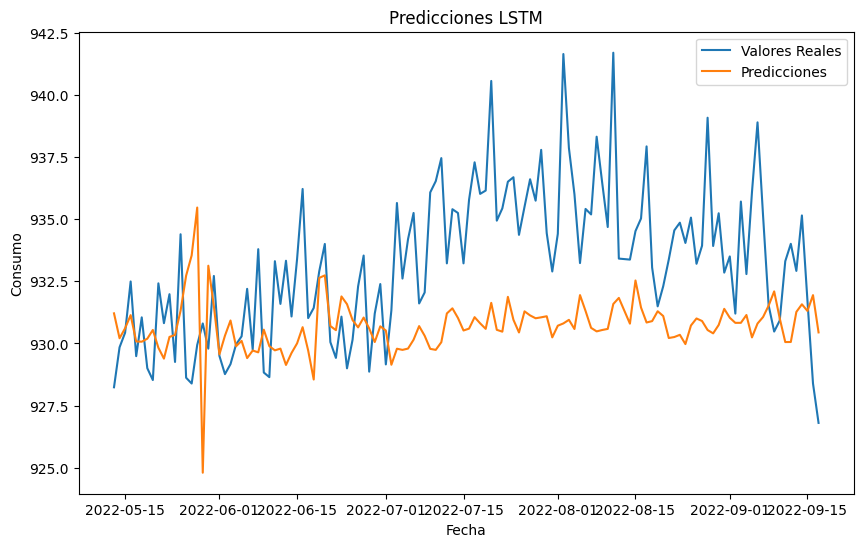

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates_ex5, scaler.inverse_transform(y_test_ex5.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates_ex5, y_pred_ex5, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss_ex5 = modeloAgrupado5.evaluate([X_train_seq5, X5_train_ext1, X5_train_ext2, X5_train_ext3, X5_train_ext4, X5_train_ext5, X5_train_ext6, X5_train_ext7, X5_train_ext8, X5_train_ext9, X5_train_ext10], y_train_ex5, verbose=0)
test_loss_ex5 = modeloAgrupado5.evaluate([X_test_seq5, X5_test_ext1, X5_test_ext2, X5_test_ext3, X5_test_ext4, X5_test_ext5, X5_test_ext6, X5_test_ext7, X5_test_ext8, X5_test_ext9, X5_test_ext10], y_test_ex5, verbose=0)
print('Train Loss:', train_loss_ex5)
print('Test Loss:', test_loss_ex5)

Train Loss: 0.007166724652051926
Test Loss: 0.0716712474822998


#Datos de un centro de transformación

Leemos el archivo .csv que contiene los datos del consumo del cliente

In [10]:
df_centro = pd.read_csv('/content/drive/MyDrive/DataLake_TFG/ConsumoHorario_ORM5965138300 .csv', sep=',')
df_centro.head()

,id,Cnt,FechaHora,Consumo
0,2675,ORM5965138300,2020-11-09 00:00:00,46000.0
1,2675,ORM5965138300,2020-11-09 01:00:00,34000.0
2,2675,ORM5965138300,2020-11-09 02:00:00,27000.0
3,2675,ORM5965138300,2020-11-09 03:00:00,25000.0
4,2675,ORM5965138300,2020-11-09 04:00:00,22000.0


Convertimos las fechas de la columna "FechaHora" a su tipo correcto

In [11]:
df_centro['FechaHora'] = pd.to_datetime(df_centro['FechaHora'])

###Datos originales

Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [ ]:
train_size_centro = int(len(df_centro) * 0.8)
train_data_centro, test_data_centro = df_centro[:train_size_centro], df_centro[train_size_centro:]

Escalamos la columna "Consumo" en train_data y en test_data para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
train_data_centro['Consumo'] = scaler.fit_transform(train_data_centro[['Consumo']])
test_data_centro['Consumo'] = scaler.transform(test_data_centro[['Consumo']])

<ipython-input-6-04fb718aae4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_centro['Consumo'] = scaler.fit_transform(train_data_centro[['Consumo']])
<ipython-input-6-04fb718aae4f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_centro['Consumo'] = scaler.transform(test_data_centro[['Consumo']])


Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM

In [ ]:
def create_sequences(dataC, seq_length):
    X = []
    y = []
    for i in range(len(dataC) - seq_length):
        X.append(dataC['Consumo'].values[i:i+seq_length])
        y.append(dataC['Consumo'].values[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train_centro, y_train_centro = create_sequences(train_data_centro, seq_length)
X_test_centro, y_test_centro = create_sequences(test_data_centro, seq_length)

Transformamos los conjuntos de datos X_train y X_test en un formato tridimensional adecuado para su uso

In [ ]:
X_train_centro = np.reshape(X_train_centro, (X_train_centro.shape[0], seq_length, 1))
X_test_centro = np.reshape(X_test_centro, (X_test_centro.shape[0], seq_length, 1))

model = Sequential(): Creamos una instancia del modelo secuencial. El modelo secuencial es una pila lineal de capas de red neuronal, donde cada capa se conecta directamente con la capa siguiente. Es uno de los tipos de modelos más comunes en Keras

model.add(LSTM(50, input_shape=(seq_length, 1))): Agregamos una capa LSTM (Long Short-Term Memory) al modelo. La capa LSTM es una capa recurrente especializada en el procesamiento de secuencias de datos. Recibe una secuencia de entrada de longitud seq_length y una dimensión de características de 1. En este caso, se configura con 50 unidades de memoria

model.add(Dense(1)): Agregamos una capa densa al modelo. Esta capa densa tiene una sola unidad, que representa la salida del modelo

model.compile(loss='mse', optimizer='adam'):  Compilamos el modelo utilizando la función de pérdida de error cuadrático medio (mse) y el optimizador Adam que es un algoritmo de optimización popular que se adapta dinámicamente a la tasa de aprendizaje durante el entrenamiento de la red.

In [ ]:
modeloCentro = Sequential()
modeloCentro.add(LSTM(50, input_shape=(seq_length, 1)))
modeloCentro.add(Dense(1))
modeloCentro.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train, y_train) durante 10 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [ ]:
modeloCentro.fit(X_train_centro, y_train_centro, epochs=10, batch_size=1)

Epoch 1/10
13012/13012 [==============================] - 64s 5ms/step - loss: 0.0033
Epoch 2/10
13012/13012 [==============================] - 59s 5ms/step - loss: 0.0024
Epoch 3/10
13012/13012 [==============================] - 59s 5ms/step - loss: 0.0024
Epoch 4/10
13012/13012 [==============================] - 56s 4ms/step - loss: 0.0024
Epoch 5/10
13012/13012 [==============================] - 56s 4ms/step - loss: 0.0024
Epoch 6/10
13012/13012 [==============================] - 55s 4ms/step - loss: 0.0024
Epoch 7/10
13012/13012 [==============================] - 56s 4ms/step - loss: 0.0024
Epoch 8/10
13012/13012 [==============================] - 55s 4ms/step - loss: 0.0024
Epoch 9/10
13012/13012 [==============================] - 56s 4ms/step - loss: 0.0023
Epoch 10/10
13012/13012 [==============================] - 55s 4ms/step - loss: 0.0023


 Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [ ]:
y_pred_centro = modeloCentro.predict(X_test_centro)
y_pred_centro = scaler.inverse_transform(y_pred_centro)

102/102 [==============================] - 0s 4ms/step


Tomamos una columna de fechas del DataFrame test_data, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [ ]:
test_dates_centro = pd.to_datetime(test_data_centro['FechaHora'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

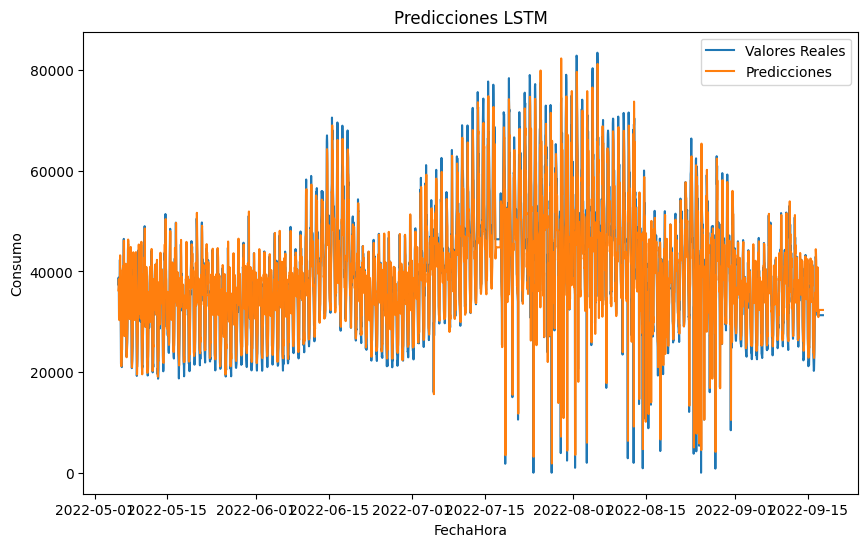

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates_centro, scaler.inverse_transform(y_test_centro.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates_centro, y_pred_centro, label='Predicciones')
plt.xlabel('FechaHora')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss_centro = modeloCentro.evaluate(X_train_centro, y_train_centro, verbose=0)
test_loss_centro = modeloCentro.evaluate(X_test_centro, y_test_centro, verbose=0)
print('Train Loss:', train_loss_centro)
print('Test Loss:', test_loss_centro)

Train Loss: 0.002466087695211172
Test Loss: 0.0035414244048297405


A partir de este punto los datos usados estarán agrupados por días, es decir, asignaremos a cada día el consumo total realizado en ese día y probaremos a añadir valirables externas para ver que efecto tienen en la predicción

###Datos agrupados con variables externas

Creamos un nueva columna "Fecha" que tendrá todas las fechas sin la parte horaria y agrupamos con la columna de consumo para tener el total de energía que se consumio ese día

In [12]:
df_centro['fecha'] = df_centro['FechaHora'].dt.date
df_centro_agrupado = df_centro.groupby('fecha')['Consumo'].sum().reset_index()
df_centro_agrupado.head()

,fecha,Consumo
0,2020-11-09,1188000.0
1,2020-11-10,1242000.0
2,2020-11-11,1288000.0
3,2020-11-12,1080000.0
4,2020-11-13,1228000.0


Convertimos las fechas de la columna "fecha" a su tipo correcto

In [13]:
df_centro_agrupado['fecha'] = pd.to_datetime(df_centro_agrupado['fecha'])

Juntamos los dataframe con los datos agrupados y las variables externas previamente preparadas usando de pivote la columna fecha, la cual debe coincidir en ambas tablas para se haga correctamente

In [14]:
df_centro_total = pd.merge(df_centro_agrupado, df_clima, on='fecha')
df_centro_total

,fecha,Consumo,tmed,prec,tmin,tmax,dir,velmedia,racha,sol,presMax,presMin
0,2020-11-09,1188000.0,11.7,2.0,6.6,16.8,21.0,2.2,9.2,3.2,944.5,940.6
1,2020-11-10,1242000.0,9.6,0.0,3.6,15.6,28.0,1.7,6.4,5.3,946.9,944.2
2,2020-11-11,1288000.0,9.0,0.2,2.9,15.2,10.0,3.1,6.7,3.8,946.0,942.4
3,2020-11-12,1080000.0,9.6,0.0,3.3,15.8,10.0,2.8,9.7,6.6,943.5,939.5
4,2020-11-13,1228000.0,10.2,0.2,3.7,16.7,11.0,0.8,6.7,7.3,941.3,939.3
...,...,...,...,...,...,...,...,...,...,...,...,...
652,2022-09-13,834903.0,22.2,1.0,17.8,26.6,19.0,4.7,16.7,6.0,932.6,930.1
653,2022-09-14,808979.0,21.2,0.0,16.1,26.3,23.0,3.3,13.9,6.7,935.3,931.7
654,2022-09-15,757819.0,20.4,0.6,16.2,24.6,30.0,1.7,11.4,4.6,936.5,934.6
655,2022-09-16,757611.0,21.0,0.0,14.2,27.9,29.0,1.7,7.8,12.0,936.6,933.2


Separamos el DataFrame inical en un conjunto de entrenamiento, que contiene el 80% de los datos iniciales, y un conjunto de prueba, que contiene el 20% de los datos iniciales restantes.

In [15]:
train_size_exC = int(len(df_centro_total) * 0.8)
train_data_exC, test_data_exC = df_centro_total[:train_size_exC], df_centro_total[train_size_exC:]

Escalamos la columna "Consumo" y todas las variables externas que se van a utilizar en el modelo, en train_data_ex y en test_data_ex para que los valores estén entre 0 y 1 utilizando MinMaxScaler

In [16]:
scaler = MinMaxScaler()
train_data_exC['Consumo'] = scaler.fit_transform(train_data_exC[['Consumo']])
train_data_exC['tmed'] = scaler.fit_transform(train_data_exC[['tmed']])
train_data_exC['prec'] = scaler.fit_transform(train_data_exC[['prec']])
train_data_exC['tmin'] = scaler.fit_transform(train_data_exC[['tmin']])
train_data_exC['tmax'] = scaler.fit_transform(train_data_exC[['tmax']])
train_data_exC['dir'] = scaler.fit_transform(train_data_exC[['dir']])
train_data_exC['velmedia'] = scaler.fit_transform(train_data_exC[['velmedia']])
train_data_exC['racha'] = scaler.fit_transform(train_data_exC[['racha']])
train_data_exC['sol'] = scaler.fit_transform(train_data_exC[['sol']])
train_data_exC['presMax'] = scaler.fit_transform(train_data_exC[['presMax']])
train_data_exC['presMin'] = scaler.fit_transform(train_data_exC[['presMin']])

test_data_exC['Consumo'] = scaler.fit_transform(test_data_exC[['Consumo']])
test_data_exC['tmed'] = scaler.fit_transform(test_data_exC[['tmed']])
test_data_exC['prec'] = scaler.fit_transform(test_data_exC[['prec']])
test_data_exC['tmin'] = scaler.fit_transform(test_data_exC[['tmin']])
test_data_exC['tmax'] = scaler.fit_transform(test_data_exC[['tmax']])
test_data_exC['dir'] = scaler.fit_transform(test_data_exC[['dir']])
test_data_exC['velmedia'] = scaler.fit_transform(test_data_exC[['velmedia']])
test_data_exC['racha'] = scaler.fit_transform(test_data_exC[['racha']])
test_data_exC['sol'] = scaler.fit_transform(test_data_exC[['sol']])
test_data_exC['presMax'] = scaler.fit_transform(test_data_exC[['presMax']])
test_data_exC['presMin'] = scaler.fit_transform(test_data_exC[['presMin']])

<ipython-input-16-09781768dafe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_exC['Consumo'] = scaler.fit_transform(train_data_exC[['Consumo']])
<ipython-input-16-09781768dafe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_exC['tmed'] = scaler.fit_transform(train_data_exC[['tmed']])
<ipython-input-16-09781768dafe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Tomamos un conjunto de datos y una longitud de secuencia, y creamos secuencias de entrada y salida a partir de los datos, que luego se utilizarán para entrenar y probar el modelo LSTM con variables externas

In [17]:
def create_sequences(data_exC, seq_length):
    X_seqC = []
    XC_ext1 = []
    XC_ext2 = []
    XC_ext3 = []
    XC_ext4 = []
    XC_ext5 = []
    XC_ext6 = []
    XC_ext7 = []
    XC_ext8 = []
    XC_ext9 = []
    XC_ext10 = []
    yC = []
    for i in range(len(data_exC) - seq_length):
        X_seqC.append(data_exC['Consumo'].values[i:i+seq_length])
        XC_ext1.append(data_exC['tmed'].values[i:i+seq_length])
        XC_ext2.append(data_exC['prec'].values[i:i+seq_length])
        XC_ext3.append(data_exC['tmin'].values[i:i+seq_length])
        XC_ext4.append(data_exC['tmax'].values[i:i+seq_length])
        XC_ext5.append(data_exC['dir'].values[i:i+seq_length])
        XC_ext6.append(data_exC['velmedia'].values[i:i+seq_length])
        XC_ext7.append(data_exC['racha'].values[i:i+seq_length])
        XC_ext8.append(data_exC['sol'].values[i:i+seq_length])
        XC_ext9.append(data_exC['presMax'].values[i:i+seq_length])
        XC_ext10.append(data_exC['presMin'].values[i:i+seq_length])
        yC.append(data_exC['Consumo'].values[i+seq_length])
    return np.array(X_seqC), np.array(XC_ext1), np.array(XC_ext2), np.array(XC_ext3), np.array(XC_ext4), np.array(XC_ext5), np.array(XC_ext6), np.array(XC_ext7), np.array(XC_ext8), np.array(XC_ext9), np.array(XC_ext10), np.array(yC)

seq_length = 5
X_train_seqC, XC_train_ext1, XC_train_ext2, XC_train_ext3, XC_train_ext4, XC_train_ext5, XC_train_ext6, XC_train_ext7, XC_train_ext8, XC_train_ext9, XC_train_ext10, y_train_exC = create_sequences(train_data_exC, seq_length)
X_test_seqC, XC_test_ext1, XC_test_ext2, XC_test_ext3, XC_test_ext4, XC_test_ext5, XC_test_ext6, XC_test_ext7, XC_test_ext8, XC_test_ext9, XC_test_ext10, y_test_exC = create_sequences(test_data_exC, seq_length)

Transformamos los conjuntos de datos X_train_seq y X_test_seq en un formato tridimensional adecuado para su uso

In [18]:
X_train_seqC = np.reshape(X_train_seqC, (X_train_seqC.shape[0], seq_length, 1))
X_test_seqC = np.reshape(X_test_seqC, (X_test_seqC.shape[0], seq_length, 1))

Definimos 11 conjuntos de datos de entrada, cada uno representado por un objeto Input de Keras con la forma (seq_length, 1). Esto indica que cada secuencia de entrada tiene una longitud de seq_length y una dimensión de 1

Después, definimos una capa LSTM con 50 unidades para cada uno de los 11 conjuntos de entrada (11 LSTMs en total). Esto se hace mediante la llamada a LSTM(50) con cada uno de los objetos Input como entrada.

Luego, todas las salidas de las LSTMs (11 en total) se concatenan usando "keras.layers.concatenate". La salida concatenada resultante será una sola secuencia.

Después de la concatenación, se agrega una capa Dense con una sola unidad para producir la salida final.

Finalmente, se crea el modelo utilizando Model, definiendo los 11 objetos Input como entradas y el objeto Dense como salida. El modelo se compila utilizando la función de pérdida de error cuadrático medio ('mse') y el optimizador Adam ('adam') para el entrenamiento.

In [19]:
seq_inputC = Input(shape=(seq_length, 1))
extC_input1 = Input(shape=(seq_length, 1))
extC_input2 = Input(shape=(seq_length, 1))
extC_input3 = Input(shape=(seq_length, 1))
extC_input4 = Input(shape=(seq_length, 1))
extC_input5 = Input(shape=(seq_length, 1))
extC_input6 = Input(shape=(seq_length, 1))
extC_input7 = Input(shape=(seq_length, 1))
extC_input8 = Input(shape=(seq_length, 1))
extC_input9 = Input(shape=(seq_length, 1))
extC_input10 = Input(shape=(seq_length, 1))
lstm_seqC = LSTM(50)(seq_inputC)
lstmC_ext1 = LSTM(50)(extC_input1)
lstmC_ext2 = LSTM(50)(extC_input2)
lstmC_ext3 = LSTM(50)(extC_input3)
lstmC_ext4 = LSTM(50)(extC_input4)
lstmC_ext5 = LSTM(50)(extC_input5)
lstmC_ext6 = LSTM(50)(extC_input6)
lstmC_ext7 = LSTM(50)(extC_input7)
lstmC_ext8 = LSTM(50)(extC_input8)
lstmC_ext9 = LSTM(50)(extC_input9)
lstmC_ext10 = LSTM(50)(extC_input10)
mergedC = keras.layers.concatenate([lstm_seqC, lstmC_ext1, lstmC_ext2, lstmC_ext3, lstmC_ext4, lstmC_ext5, lstmC_ext6, lstmC_ext7, lstmC_ext8, lstmC_ext9, lstmC_ext10])
outputC = Dense(1)(mergedC)
modeloCentroAgrupado = Model(inputs=[seq_inputC, extC_input1, extC_input2, extC_input3, extC_input4, extC_input5, extC_input6, extC_input7, extC_input8, extC_input9, extC_input10], outputs=outputC)
modeloCentroAgrupado.compile(loss='mse', optimizer='adam')

Entrenamos el modelo utilizando el conjunto de datos de entrenamiento (X_train_seq, y_train_ex y todos los conjuntos de datos externos) durante 50 épocas, actualizando los pesos después de cada ejemplo de entrenamiento individualmente

In [20]:
modeloCentroAgrupado.fit([X_train_seqC, XC_train_ext1, XC_train_ext2, XC_train_ext3, XC_train_ext4, XC_train_ext5, XC_train_ext6, XC_train_ext7, XC_train_ext8, XC_train_ext9, XC_train_ext10], y_train_exC, epochs=50, batch_size=1)

Epoch 1/50
520/520 [==============================] - 40s 23ms/step - loss: 0.0130
Epoch 2/50
520/520 [==============================] - 13s 25ms/step - loss: 0.0067
Epoch 3/50
520/520 [==============================] - 12s 23ms/step - loss: 0.0066
Epoch 4/50
520/520 [==============================] - 8s 15ms/step - loss: 0.0061
Epoch 5/50
520/520 [==============================] - 8s 14ms/step - loss: 0.0054
Epoch 6/50
520/520 [==============================] - 15s 28ms/step - loss: 0.0052
Epoch 7/50
520/520 [==============================] - 16s 31ms/step - loss: 0.0048
Epoch 8/50
520/520 [==============================] - 12s 23ms/step - loss: 0.0043
Epoch 9/50
520/520 [==============================] - 11s 22ms/step - loss: 0.0043
Epoch 10/50
520/520 [==============================] - 8s 16ms/step - loss: 0.0040
Epoch 11/50
520/520 [==============================] - 11s 20ms/step - loss: 0.0039
Epoch 12/50
520/520 [==============================] - 11s 22ms/step - loss: 0.0040
Epoc

Utilizamos el modelo entrenado para realizar predicciones en los datos de prueba y luego reviertimos la escala de las predicciones para obtener los valores originales

In [21]:
y_pred_exC = modeloCentroAgrupado.predict([X_test_seqC, XC_test_ext1,  XC_test_ext2,  XC_test_ext3,  XC_test_ext4,  XC_test_ext5,  XC_test_ext6,  XC_test_ext7,  XC_test_ext8,  XC_test_ext9,  XC_test_ext10])
y_pred_exC = scaler.inverse_transform(y_pred_exC)

4/4 [==============================] - 3s 7ms/step


Tomamos una columna de fechas del DataFrame test_data_ex, seleccionamos las fechas a partir del índice seq_length hasta el final y las convertimos a su tipo correcto

In [22]:
test_dates_exC = pd.to_datetime(test_data_exC['fecha'].values[seq_length:])

Graficamos los resultados de las predicciones realizadas junto con los valores reales para poder evaluar la precisión del modelo.

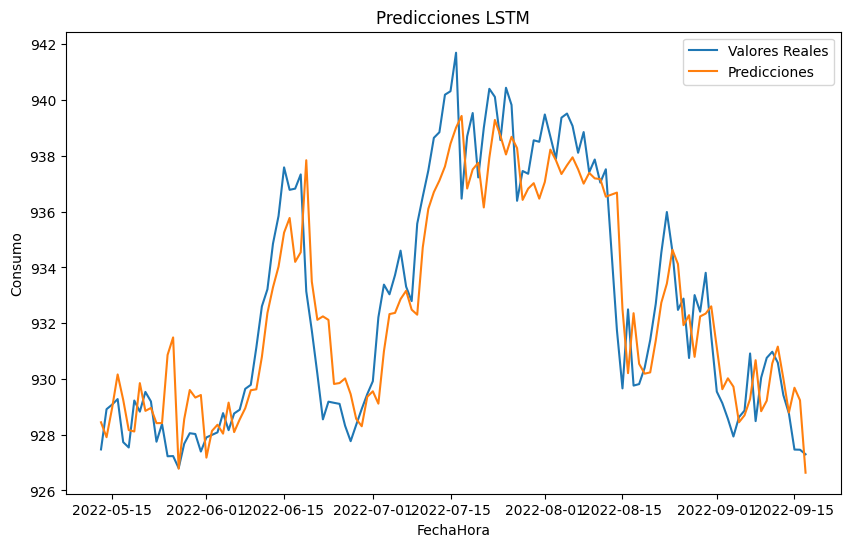

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(test_dates_exC, scaler.inverse_transform(y_test_exC.reshape(-1, 1)), label='Valores Reales')
plt.plot(test_dates_exC, y_pred_exC, label='Predicciones')
plt.xlabel('FechaHora')
plt.ylabel('Consumo')
plt.title('Predicciones LSTM')
plt.legend()
plt.show()

Evaluamos el rendimiento del modelo utilizando las métricas de pérdida

In [ ]:
train_loss_exC = modeloCentroAgrupado.evaluate([X_train_seqC, XC_train_ext1, XC_train_ext2, XC_train_ext3, XC_train_ext4, XC_train_ext5, XC_train_ext6, XC_train_ext7, XC_train_ext8, XC_train_ext9, XC_train_ext10], y_train_exC, verbose=0)
test_loss_exC = modeloCentroAgrupado.evaluate([X_test_seqC, XC_test_ext1, XC_test_ext2, XC_test_ext3, XC_test_ext4, XC_test_ext5, XC_test_ext6, XC_test_ext7, XC_test_ext8, XC_test_ext9, XC_test_ext10], y_test_exC, verbose=0)
print('Train Loss:', train_loss_exC)
print('Test Loss:', test_loss_exC)

Train Loss: 0.0035194698721170425
Test Loss: 0.02229832299053669
